## Import libraries

In [160]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import biosppy
# import neurokit2 as nk
import pickle
# import pywt

from scipy import signal, fft
from scipy.interpolate import interp1d
# from biosppy.signals import ecg, eeg, resp, eda

# from tsfresh import select_features
# from tsfresh import extract_relevant_features
# from tsfresh.feature_extraction import feature_calculators
# import tsfresh

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipe
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (roc_auc_score, confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, 
                            plot_roc_curve, log_loss, f1_score, precision_score, fbeta_score, ConfusionMatrixDisplay,
                            average_precision_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
                                GradientBoostingClassifier)

# import xgboost as xgb
# import lightgbm as lgbm

from sklearn.pipeline import Pipeline as skpipe

In [94]:
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

## Load data

In [99]:
agg_table = pd.read_csv('./data/agg_table.csv')

In [100]:
# create binary columns for OvR classification later
agg_table['is_B'] = agg_table['event'].map(lambda x: 1 if x=='B' else 0)
agg_table['is_D'] = agg_table['event'].map(lambda x: 1 if x=='D' else 0)

### Process the data to be ready for modeling
Train test split, then scale

In [35]:
X = agg_table.drop(columns=['event', 'is_B', 'is_D'])
y = agg_table['event']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, stratify = y)


### Create iterative modeling functions

In [35]:
resamplers = {'smote': SMOTE(random_state=42),
              'adasyn': ADASYN(random_state=42)}

models = {'lr': LogisticRegression(max_iter=5000, random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=101),
          'ada': AdaBoostClassifier(DecisionTreeClassifier(), random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
#           'xgb': xgb.XGBClassifier(random_state=42),
          'lgbm': lgbm.LGBMClassifier(random_state=42),
          'sgd':SGDClassifier(random_state=42)
         }

def gscv_creator(resampler, model, pipe_params, n_jobs=-1, resample=False, pca=False):
    """
    helps me instantiate my models quickly. 
    ensure that your parameters for gridsearching are prefixed correctly according to the dunder__ convention 
    leave n_jobs as -1 unless you have good reason for making it slower and more painful than necessary.
    """
    if resample and pca is False:
        pipe = imbpipe([
            ('ss', StandardScaler()),
            (resampler, resamplers[resampler]),
            (model, models[model]),
        ])
    elif resample and pca:
        pipe = imbpipe([
            ('ss', StandardScaler()),
            (resampler, resamplers[resampler]),
            ('pca', PCA()),
            (model, models[model]),
        ])
    else:
        pipe = skpipe([
            ('ss', StandardScaler()),
            (model, models[model]),
        ])
    
    gs = GridSearchCV(pipe,
                      pipe_params,
                      cv=5,
                      scoring='roc_auc_ovr',
                      verbose=1,
                      n_jobs=n_jobs) # force maximum number of concurrent workers

    return gs

In [9]:
# this function prints a bunch of summary stats about our GridSearchCV object. 
# it requires that our GridSearchCV object has been fit on the training set already.

def gscv_result_printer(gs, X=None, y=None):
    """
    feed in a GridSearchCV that is already fit on X_train, y_train.
    prints out a bunch of stuff to compare
    """
    print("Best CV score: {}".format(gs.best_score_))
    print("Best params: {}".format(gs.best_params_))
    print('----------')
    predictions = gs.predict(X_train)
    try:
        probas = gs.predict_proba(X_train)
        print("Training ROC AUC: {}".format(roc_auc_score(y_train, probas, multi_class='ovr', average='macro')))
    except:
        print('Model has no predict_proba function')
    print('----------')
    # pass in X and Y arguments if you would like to score the gs object on something else, like the X_val set.
    if X is not None:
        predictions = gs.predict(X)
        try:
            probas = gs.predict_proba(X)
            print("Validation ROC AUC: {}".format(roc_auc_score(y, probas, multi_class='ovr', average='macro')))
        except:
            print('Model has no predict_proba function')            

#         tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
#         print(pd.DataFrame({'WNV present': [tp,fn],
#                             'WNV not present': [fp,tn]},
#                            index=['Predicted WNV', 'No predicted WNV']))

        

## Simple RandomForest Model
We'll run a RandomForest Model as a baseline model to beat

In [36]:
y = agg_table['event']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, stratify = y)

<AxesSubplot:xlabel='event', ylabel='count'>

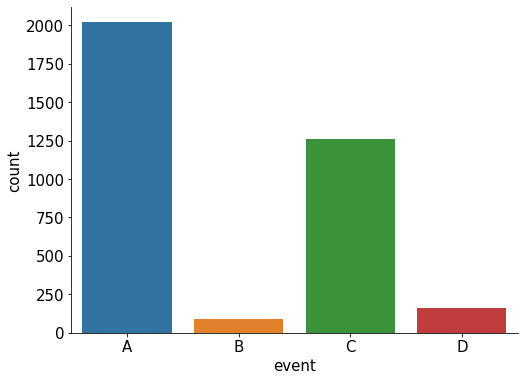

In [44]:
sns.countplot(x=y, order=['A','B','C','D'])

Our classes are highly imbalanced, but that doesn't necessarily mean that our model's can't do well without resampling. First we try running our model without SMOTE

In [20]:
# RF without SMOTE
pipe_params = {
    'rf__n_estimators':[100],
    'rf__max_depth':[None,5],
    'rf__min_samples_leaf':[2,5]
}

rf_cv = gscv_creator('smote', 'rf', pipe_params, resample=False)
rf_cv.fit(X_train, y_train)
gscv_result_printer(rf_cv, X_val, y_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best CV score: 0.8432105989007672
Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 100}
----------
Training ROC AUC: 0.9999998544828028
----------
Validation ROC AUC: 0.8641305265903303


Our macro ROC AUC is a respectable 0.86, but as we are doing multi-class classification, we want to be sure that all of our classes show high discriminability, not just some. The below function will help us to calculate the ROC for each class vs rest, allowing us to examine whether there is any class in particular that isn't doing so well.

In [88]:
def individual_ovr_roc_score(df):
    for event in ['A','B','C','D']:
        probas = df[event]
        y = (df['y_true'].map(lambda x: 1 if x==event else 0)).astype(int)
        print('OvR AUROC for {} vs rest: {}'.format(event, roc_auc_score(y, probas)))


In [22]:
probas = rf_cv.predict_proba(X_val)
preds = rf_cv.predict(X_val)
results = pd.DataFrame(probas, columns=rf_cv.best_estimator_.classes_)
results['y_true'] = y_val.reset_index(drop=True)
results['y_preds'] = preds
individual_ovr_roc_score(results)

OvR AUROC for A vs rest: 0.9122976583372624
OvR AUROC for B vs rest: 0.7564143173899273
OvR AUROC for C vs rest: 0.9612383631370973
OvR AUROC for D vs rest: 0.8265717674970344


From this we can see that in fact, our 2 minority classes aren't doing that well. Our macro ROC AUC is high only because the scores for our majority classes is high. This isn't what we want, as the minority classes are what we're interested in.

We'll run this model again with SMOTE and see how our scores change.

In [25]:
# RF with SMOTE
pipe_params = {
    'rf__n_estimators':[100],
    'rf__max_depth':[None,5],
    'rf__min_samples_leaf':[2,5]
}

rf_cv = gscv_creator('smote', 'rf', pipe_params, resample=True)
rf_cv.fit(X_train, y_train)
gscv_result_printer(rf_cv, X_val, y_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best CV score: 0.8844932881161347
Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 100}
----------
Training ROC AUC: 1.0
----------
Validation ROC AUC: 0.886332193930542


In [26]:
probas = rf_cv.predict_proba(X_val)
preds = rf_cv.predict(X_val)
results = pd.DataFrame(probas, columns=rf_cv.best_estimator_.classes_)
results['y_true'] = y_val.reset_index(drop=True)
results['y_preds'] = preds
individual_ovr_roc_score(results)

OvR AUROC for A vs rest: 0.907884121745508
OvR AUROC for B vs rest: 0.7577869285186358
OvR AUROC for C vs rest: 0.9665349496573125
OvR AUROC for D vs rest: 0.9131227758007118


With resampling, we've managed to pull the ROC for the D minority class above 0.9, however, class B is still doing quite badly. Now that we know resampling can improve our model, we'll continue to resample our training data.

## Gridsearching over best LGBM params

Boosted tree models are a popularly used for problems involving imbalanced datasets due to the their ability to learn iteratively from their mistakes. 2 of the most popular boosted tree models are XGBoost and Light GBM. For our project, we will using and tuning the Light GBM.

The Light Gradient Boosting Model is a popular classifier online because of its purported increased speed over many other booster models. One unique feature about it is that rather than growing trees in a level-wise fashion, it grows trees in a leaf-wise fashion first, meaning it first builds trees on the best leaf first until it reaches the max depth, before building on the other leaves. This means that when tuning this model, we have to be careful when setting both the max number of leaves and the max depth of the model, as leaves are no longer limited by the depth of the tree.

We'll use sklearn's Gridsearch as a start point to get some good params before moving on to finetuning LGBM manually and intentionally. Doing so will give us greater control and finesse over the hyperparameters.

In [36]:
# LGBM with SMOTE
pipe_params = {
    'smote__k_neighbors':[3,5],
    'lgbm__objective':['multiclass'],
    'lgbm__max_depth':[None, 2, 3],
    'lgbm__subsample':[0.5], 
    'lgbm__learning_rate':[0.3,0.5],
    'lgbm__n_estimators':[300],
    'lgbm__reg_alpha':[0,0.5, 0.7], 
    'lgbm__reg_lambda':[1,0.5, 0.7], 
    'lgbm__min_child_samples':[10,],
    'lgbm__num_leaves':[4,8,16],
#     'lgbm__feature_fraction:[0.8,1]'
#     'lgbm__extra_trees':[True]
}

lgbm_smote_cv = gscv_creator('smote','lgbm', pipe_params, resample=True)
lgbm_smote_cv.fit(X_train, y_train)
gscv_result_printer(lgbm_smote_cv, X_val, y_val)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best CV score: 0.9109400083965864
Best params: {'lgbm__learning_rate': 0.3, 'lgbm__max_depth': None, 'lgbm__min_child_samples': 10, 'lgbm__n_estimators': 300, 'lgbm__num_leaves': 8, 'lgbm__objective': 'multiclass', 'lgbm__reg_alpha': 0, 'lgbm__reg_lambda': 0.7, 'lgbm__subsample': 0.5, 'smote__k_neighbors': 3}
----------
Training ROC AUC: 1.0
----------
Validation ROC AUC: 0.8996449676467682


In [12]:
# pickle our model for easier loading next time
import pickle

# pickle.dump(lgbm_smote_cv, open('./data/lgbmsmote.pickle', 'wb'))

In [40]:
probas = lgbm_smote_cv.predict_proba(X_val)
preds = lgbm_smote_cv.predict(X_val)
results = pd.DataFrame(probas, columns=lgbm_smote_cv.best_estimator_.classes_)
results['y_true'] = y_val.reset_index(drop=True)
results['y_preds'] = preds
results

,A,B,C,D,y_true,y_preds
0,0.244957,2.486594e-03,3.229770e-03,7.493270e-01,A,D
1,0.999462,2.192225e-04,3.142899e-04,4.668414e-06,A,A
2,0.999857,7.226537e-08,1.917478e-07,1.425593e-04,A,A
3,0.999400,5.220836e-05,5.200959e-04,2.746204e-05,A,A
4,1.000000,6.898539e-08,5.742500e-08,6.048732e-08,A,A
...,...,...,...,...,...,...
878,0.473468,7.050389e-04,5.256452e-01,1.818205e-04,C,C
879,0.588466,1.596099e-05,5.851417e-04,4.109332e-01,D,A
880,0.010118,2.192096e-05,9.898566e-01,3.129556e-06,C,C
881,0.999918,2.334273e-07,7.891270e-05,2.990156e-06,A,A


In [41]:
individual_ovr_roc_score(results)
print('Macro AUROC: {}'.format(roc_auc_score(y_val, lgbm_smote_cv.predict_proba(X_val), multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.9470689926135472
OvR AUROC for B vs rest: 0.7454862210959772
OvR AUROC for C vs rest: 0.9857399593686512
OvR AUROC for D vs rest: 0.9202846975088967
Macre AUROC: 0.8996449676467682


Our macro AUROC is now just barely underneath 0.9, but our AUROC for class B is still not doing well. This is the class that we will need to pay close attention to when continuing to tune our model.

## LGBM without pipeline

If we run LGBM outside of sklearn's pipeline, we can use its early stopping feature. This allows us to set a high number of estimators without worrying about overfitting. This also lets us further tune our model parameter by parameter, as we can instantly run the next set of params once early stopping kicks in.

In [89]:
ss = StandardScaler()
Xtrain_sc = ss.fit_transform(X_train)
Xval_sc = ss.transform(X_val)

adasyn = ADASYN(random_state=42, n_neighbors=3)
X_res, y_res = adasyn.fit_resample(Xtrain_sc, y_train)

In [90]:
lgbm_clf = lgbm.LGBMClassifier(objective='multiclass',
                               num_class=4,
                               max_depth=10,
                               subsample=0.5,
                               learning_rate=0.3,
                               n_estimators=1000,
                               reg_alpha=0,
                               reg_lambda=0.7,
                               min_child_samples=10,
                               num_leaves=16,
#                                feature_fraction=0.9,
                               bagging_seed=420,
                               bagging_fraction=0.5,
                               extra_trees=True,
                               random_state=42)
lgbm_clf.fit(X_res, y_res, 
             eval_set=[(Xval_sc, y_val)], 
             eval_metric='multi_logloss', 
             early_stopping_rounds=50)

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's multi_logloss: 1.19486
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.09115
[3]	valid_0's multi_logloss: 1.01494
[4]	valid_0's multi_logloss: 0.942956
[5]	valid_0's multi_logloss: 0.882098
[6]	valid_0's multi_logloss: 0.837698
[7]	valid_0's multi_logloss: 0.795043
[8]	valid_0's multi_logloss: 0.755167
[9]	valid_0's multi_logloss: 0.720716
[10]	valid_0's multi_logloss: 0.686382
[11]	valid_0's multi_logloss: 0.665505
[12]	valid_0's multi_logloss: 0.649195
[13]	valid_0's multi_logloss: 0.623207
[14]	valid_0's multi_logloss: 0.600758
[15]	valid_0's multi_logloss: 0.581206
[16]	valid_0's multi_logloss: 0.568196
[17]	valid_0's multi_logloss: 0.557707
[18]	valid_0's multi_logloss: 0.542895
[19]	valid_0's multi_logloss: 0.531778
[20]	valid_0's multi_logloss: 0.524573
[21]	valid_0's multi_logloss: 0.518174
[22]	valid_0's 

LGBMClassifier(bagging_fraction=0.5, bagging_seed=420, extra_trees=True,
               learning_rate=0.3, max_depth=10, min_child_samples=10,
               n_estimators=1000, num_class=4, num_leaves=16,
               objective='multiclass', random_state=42, reg_alpha=0,
               reg_lambda=0.7, subsample=0.5)

In [91]:
probas = lgbm_clf.predict_proba(Xval_sc)
preds = lgbm_clf.predict(Xval_sc)
results = pd.DataFrame(probas, columns=lgbm_clf.classes_)
results['y_true'] = y_val.reset_index(drop=True)
results['y_preds'] = preds

In [92]:
individual_ovr_roc_score(results)
print('Macre AUROC: {}'.format(roc_auc_score(y_val, lgbm_clf.predict_proba(Xval_sc), multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.9407564565980407
OvR AUROC for B vs rest: 0.7587899904973077
OvR AUROC for C vs rest: 0.9806387158707833
OvR AUROC for D vs rest: 0.9250296559905101
Macre AUROC: 0.9013037047391605


We've finally managed to crack the 0.9 mark for macro ROC AUC. Our B class is however, still not doing very well, sitting at 0.76. To better understand what is going on, let's plot the ROC curve for our minority classes.

### Plotting ROC curves

In [66]:
# we create binary truth columns for class B and D
results['y_isB'] = (results['y_true'].map(lambda x: 1 if x=='B' else 0)).astype(int)
results['y_isD'] = (results['y_true'].map(lambda x: 1 if x=='D' else 0)).astype(int)

In [47]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

def precision(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    try:
        return true_positive/ (true_positive + false_positive)
    except:
        return 1

In [48]:
def ovr_pr_curve(df, target_class, target_proba):
    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, 5000)

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(df, target_class, target_proba, prob) for prob in thresholds]
    precision_values = [precision(df, target_class, target_proba, prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(tpr_values, # True Positive Rate/Recall on X-axis
             precision_values, # Precision on Y-axis
             label='PR Curve')

    # Label axes.
    plt.title('PR Curve for {} vs Rest'.format(target_proba), fontsize=22)
    plt.ylabel('Precision', fontsize=18)
    plt.xlabel('Recall \n (True Positive Rate)', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [49]:
def ovr_roc_curve(df, target_class, target_proba, n_thresholds=5000):
    plt.figure(figsize = (10,7))

    # Create threshold values.
    thresholds = np.linspace(0, 1, n_thresholds)

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(df, target_class, target_proba, prob) for prob in thresholds]
    fpr_values = [FPR(df, target_class, target_proba, prob) for prob in thresholds]
    

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title('ROC Curve for {} vs Rest'.format(target_proba), fontsize=22)
    plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
    plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

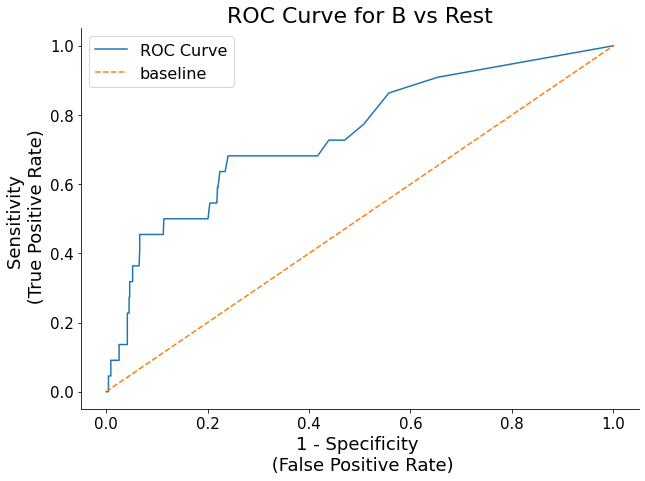

In [67]:
ovr_roc_curve(results, 'y_isB', 'B')

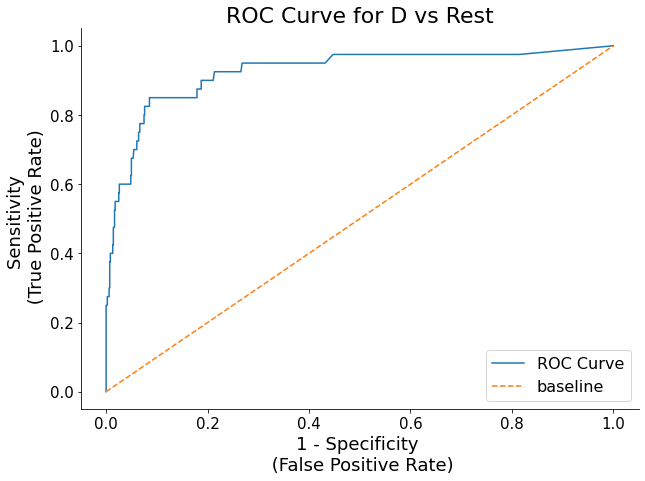

In [68]:
ovr_roc_curve(results, 'y_isD', 'D')

We see that the ROC curve for class B is not great. Remember that a skilled classifier has its curve at the top left corner of the ROC graph. The current curve is obviously very far from that corner. This indicates low discriminability for our class B, and we need to find a way to fix this. Our ROC curve for class D is quite respectable, although I believe that we should also be able to improve this further. 

## Problem with class B

Our event B is not doing as well as other classes. I posit that the labelling of this particular event is not well defined. According to Kaggle, this event is defined as showing pilots a jumpscare in a movie clip. However, we saw in our EDA that in the SS experiment, this event lasts on average 15 seconds. A jumpscare, however, is typically an instantaneous event in a movie that triggers a one-off feeling of shock or surprise in the viewer. It feels unreasonable then to assume that the viewer would be *continuously* shocked/surprised to the same degree for 15 seconds straight. It is more likely that the feeling of shock/surprise would subside after 5-10 seconds for example. So it is possible that the part of the signal that is *most* representative of the the attentional state of shock/surprise actually only lies in the front part of the event.

We're going to keep only the event B chunks that correspond to the first 5 seconds of that event. This is however, going to drastically reduce the amount of data we have to work with.

In [456]:
agg_table[agg_table['event']=='B'].head(30)

,eeg_fp1_variance,eeg_fp1_mean,eeg_fp1_skewness,eeg_fp1_kurtosis,eeg_fp1_abs_energy,eeg_f7_variance,eeg_f7_mean,eeg_f7_skewness,eeg_f7_kurtosis,eeg_f7_abs_energy,...,eeg_cz_cd5,eeg_cz_cd4,eeg_cz_cd3,eeg_o2_ca5,eeg_o2_cd5,eeg_o2_cd4,eeg_o2_cd3,event,is_B,is_D
146,193.909024,-1.993427,-0.138457,-0.183441,2.532900e+05,145.696971,-0.555932,-0.210859,-0.129302,1.868877e+05,...,15834.262698,19539.071187,24515.553325,7.874182e+04,6046.282075,11835.091383,12459.773769,B,1,0
147,1959.352280,10.844302,3.681709,14.456161,2.658497e+06,206.863768,2.529517,2.011104,6.105223,2.729756e+05,...,26552.187081,18423.055072,15259.199267,7.031350e+04,7171.095776,10784.361122,11902.877742,B,1,0
309,1497.010759,11.948684,3.141844,11.194965,2.098921e+06,803.246702,8.806395,1.375833,1.409384,1.127423e+06,...,24895.681280,16655.233734,10028.941749,8.164440e+04,17409.794993,27842.754942,17418.754102,B,1,0
310,2284.255117,9.542292,2.632838,7.323997,3.040397e+06,970.240564,-5.009710,-0.514257,1.773211,1.274032e+06,...,27392.670991,19177.410412,13131.545273,1.220718e+05,26798.482284,21192.450361,17124.105002,B,1,0
311,6829.968564,20.006386,0.887992,1.246595,9.254687e+06,3195.926537,9.903688,-0.184613,0.557562,4.216332e+06,...,78452.732076,21089.051122,10917.217707,2.179076e+06,71550.291396,44785.339730,21157.870168,B,1,0
471,972.218729,4.790667,2.203171,9.059851,1.273817e+06,1985.738128,2.499599,1.128791,1.852309,2.549742e+06,...,27661.586153,47515.087312,120402.762100,7.926957e+06,15744.595432,57116.803165,161870.055644,B,1,0
472,2554.158984,11.488511,1.517695,3.240426,3.438265e+06,1359.151060,2.833508,1.026060,1.483338,1.749990e+06,...,66464.827048,43903.041022,108438.415418,3.918337e+06,25921.987579,48188.729433,108249.850001,B,1,0
473,2898.459562,8.397177,1.039936,1.209416,3.800284e+06,1556.002590,0.487168,-0.221650,2.600933,1.991987e+06,...,86932.433061,61228.046718,114100.522335,2.178681e+05,34658.196093,56094.719171,105601.914252,B,1,0
508,476.591342,0.727632,0.398686,2.701677,6.107146e+05,555.961426,1.634864,0.270061,4.325425,7.150518e+05,...,29904.857761,59444.052619,177117.733237,8.238737e+04,25210.392666,62568.252393,188957.409332,B,1,0
509,3117.662521,7.537865,1.886044,4.764289,4.063337e+06,893.078506,2.181859,1.293629,2.293283,1.149234e+06,...,35120.084652,43861.614820,144447.271222,1.783637e+05,14699.237834,43524.461119,142001.534819,B,1,0


From above, we can see that each Surprised/Startled event that occurred during the experiment yields 2-3 5s chunks of signal. We only want to keep the first such chunk from each event, so what we'll do is go through all the chunks belonging to event B, and drop all the chunks that don't correspond to the first 5s of each event.

In [476]:
# look at the current indices for event B chunks
agg_table[agg_table['event']=='B'].index

Int64Index([ 146,  147,  309,  310,  311,  471,  472,  473,  508,  509,  510,
             672,  673,  674,  709,  710,  873,  874,  909,  910,  911, 1073,
            1074, 1075, 1110, 1111, 1112, 1275, 1276, 1311, 1312, 1475, 1476,
            1477, 1512, 1513, 1676, 1677, 1678, 1713, 1714, 1715, 1877, 1878,
            1913, 1914, 1915, 2078, 2079, 2114, 2115, 2116, 2279, 2280, 2281,
            2316, 2317, 2318, 2481, 2482, 2517, 2518, 2680, 2681, 2716, 2717,
            2718, 2880, 2881, 2882, 2917, 2918, 3080, 3081, 3082, 3117, 3118,
            3119, 3281, 3282, 3317, 3318, 3319, 3480, 3481, 3516, 3517, 3518],
           dtype='int64')

In [46]:
cur_idx = agg_table[agg_table['event']=='B'].index[0]
new_list = []
# going through each chunk's index, keep a list of indices that consecutively follow the previous index
# these are the indices of chunks that directly follow the first 5s of an event B
for idx in agg_table[agg_table['event']=='B'].index:
    new_idx = idx
    if new_idx == (cur_idx + 1):
        new_list.append(new_idx)
    cur_idx = new_idx

In [70]:
# comparing this list with the original indices for event B chunks, we see that we've found the correct indices to drop 
new_list

[147,
 310,
 311,
 472,
 473,
 509,
 510,
 673,
 674,
 710,
 874,
 910,
 911,
 1074,
 1075,
 1111,
 1112,
 1276,
 1312,
 1476,
 1477,
 1513,
 1677,
 1678,
 1714,
 1715,
 1878,
 1914,
 1915,
 2079,
 2115,
 2116,
 2280,
 2281,
 2317,
 2318,
 2482,
 2518,
 2681,
 2717,
 2718,
 2881,
 2882,
 2918,
 3081,
 3082,
 3118,
 3119,
 3282,
 3318,
 3319,
 3481,
 3517,
 3518]

In [47]:
# create a new table with these extra event B chunks dropped
agg_table2 = agg_table.drop(index=new_list)

<AxesSubplot:xlabel='event', ylabel='count'>

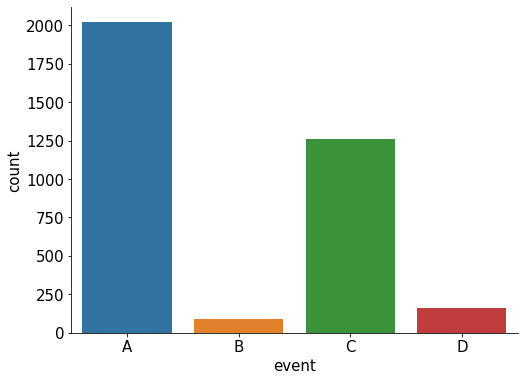

In [45]:
sns.countplot(x=agg_table['event'], order=['A','B','C','D'])

In [72]:
# check original distribution of classes
agg_table['event'].value_counts()

A    2020
C    1263
D     161
B      88
Name: event, dtype: int64

<AxesSubplot:xlabel='event', ylabel='count'>

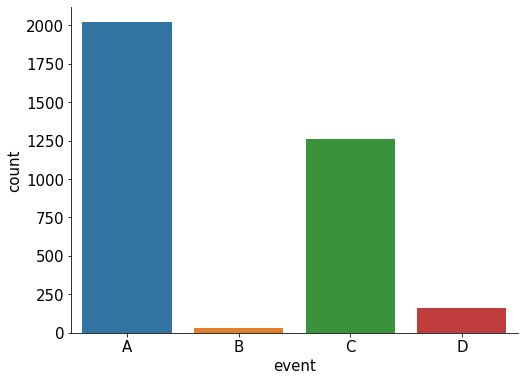

In [48]:
sns.countplot(x=agg_table2['event'], order=['A','B','C','D'])

In [73]:
# check new distribution of classes after dropping
agg_table2['event'].value_counts()

A    2020
C    1263
D     161
B      34
Name: event, dtype: int64

### Remodeling using trimmed down dataset. 
After dropping the above event B chunks, we're only left with 34 remaining event B observations, but hopefully these observations will be more representative of the actual attentional state of Surprised/Startled. We'll run a new LGBM model on this dataset.

In [479]:
agg_table2

,eeg_fp1_variance,eeg_fp1_mean,eeg_fp1_skewness,eeg_fp1_kurtosis,eeg_fp1_abs_energy,eeg_f7_variance,eeg_f7_mean,eeg_f7_skewness,eeg_f7_kurtosis,eeg_f7_abs_energy,...,eeg_cz_cd5,eeg_cz_cd4,eeg_cz_cd3,eeg_o2_ca5,eeg_o2_cd5,eeg_o2_cd4,eeg_o2_cd3,event,is_B,is_D
0,536.262427,-1.629910,-1.030400,2.685942,6.898164e+05,86.292108,-0.457109,-0.272935,0.256866,110721.352297,...,25161.304914,16531.533390,23948.963365,79033.608473,11400.415515,9439.433325,12169.547707,C,0,0
1,1441.391024,1.666653,0.091707,0.356019,1.848536e+06,119.740835,0.407402,0.194576,0.510444,153480.717967,...,41761.576829,12768.042665,17496.028771,102024.362980,15617.724957,9856.256930,10725.471624,C,0,0
2,268.009911,-0.224897,0.404622,0.158087,3.431174e+05,84.413973,-0.112212,0.004205,0.066054,108066.002568,...,22670.418222,13873.557127,23258.793030,43985.954778,11097.400333,7865.590739,13919.313517,C,0,0
3,132.411011,-0.312152,0.114657,0.805623,1.696108e+05,87.486334,0.407035,0.053012,0.002013,112194.575533,...,17698.071053,15554.738899,18164.480333,75457.148782,7281.922716,7863.836843,13107.148049,C,0,0
4,538.814936,-4.168226,-1.699561,3.715753,7.119220e+05,116.336753,-0.410986,-0.028529,-0.015221,149127.247963,...,34042.678666,17633.687074,20907.460782,84994.196017,13891.818217,10441.204649,14622.620416,C,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3527,88.719879,-1.460203,-0.727657,1.109143,1.162907e+05,70.169624,-0.319277,-0.443073,0.782844,89947.599153,...,4895.451542,3995.475276,6369.566064,55490.290685,2914.172594,3500.193926,9865.406319,A,0,0
3528,542.715765,8.840624,2.790261,12.550842,7.947167e+05,452.516406,5.743849,2.433574,8.753723,621450.503020,...,6408.707849,7603.605500,8751.884622,92582.815665,5039.649230,4697.039747,9995.131772,A,0,0
3529,1201.659961,4.112933,1.876079,5.892369,1.559778e+06,618.168392,2.506329,1.654695,5.425146,799296.098547,...,9546.829358,5328.187888,6784.996911,33676.337778,4392.693913,3416.319308,9842.032000,A,0,0
3530,60.832757,-0.508906,-0.221097,0.120249,7.819743e+04,61.512752,-0.180087,-0.182449,0.070883,78777.835237,...,7472.033517,5425.650664,4601.674171,55184.487582,2935.343712,3455.832787,7197.634883,A,0,0


In [74]:
y2 = agg_table2['event']
X2 = agg_table2.drop(columns=['event', 'is_B', 'is_D'])
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, random_state = 42, stratify = y2)

This time, we're also going to specify how to resample our minority classes. To avoid overdistorting the true distributions of our minority classes, we're going to allow ADASYN to resample these classes, but to a lesser extent this time. This means that while we get more minority samples, we are not going to create so many that our classes become fully balanced. 

In [105]:
ss = StandardScaler()
X2train_sc = ss.fit_transform(X2_train)
X2val_sc = ss.transform(X2_val)

adasyn = ADASYN(random_state=42, n_neighbors=5, 
                sampling_strategy={'B':150, 'D':200}
               )
sm = SMOTE(random_state=42)
X2_res, y2_res = adasyn.fit_resample(X2train_sc, y2_train)

In [106]:
lgbm_clf2 = lgbm.LGBMClassifier(objective='multiclass',
                               num_class=4,
                               max_depth=10,
                               subsample=0.5,
                               learning_rate=0.3,
                               n_estimators=1000,
                               reg_alpha=0,
                               reg_lambda=0.7,
                               min_child_samples=10,
                               num_leaves=16,
                               bagging_seed=420,
                               bagging_fraction=0.5,
                               extra_trees=True,
                               random_state=42)
lgbm_clf2.fit(X2_res, y2_res, 
             eval_set=[(X2val_sc, y2_val)], 
             eval_metric='multi_logloss', 
             early_stopping_rounds=50
             )

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=0.5 will be ignored. Current value: bagging_fraction=0.5
[1]	valid_0's multi_logloss: 0.814384
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 0.748633
[3]	valid_0's multi_logloss: 0.705633
[4]	valid_0's multi_logloss: 0.662758
[5]	valid_0's multi_logloss: 0.62906
[6]	valid_0's multi_logloss: 0.600721
[7]	valid_0's multi_logloss: 0.572633
[8]	valid_0's multi_logloss: 0.556006
[9]	valid_0's multi_logloss: 0.534746
[10]	valid_0's multi_logloss: 0.522087
[11]	valid_0's multi_logloss: 0.509733
[12]	valid_0's multi_logloss: 0.490415
[13]	valid_0's multi_logloss: 0.481961
[14]	valid_0's multi_logloss: 0.468879
[15]	valid_0's multi_logloss: 0.461318
[16]	valid_0's multi_logloss: 0.454869
[17]	valid_0's multi_logloss: 0.443369
[18]	valid_0's multi_logloss: 0.438559
[19]	valid_0's multi_logloss: 0.433332
[20]	valid_0's multi_logloss: 0.425458
[21]	valid_0's multi_logloss: 0.419839
[22]	valid_0'

LGBMClassifier(bagging_fraction=0.5, bagging_seed=420, extra_trees=True,
               learning_rate=0.3, max_depth=10, min_child_samples=10,
               n_estimators=1000, num_class=4, num_leaves=16,
               objective='multiclass', random_state=42, reg_alpha=0,
               reg_lambda=0.7, subsample=0.5)

In [107]:
probas = lgbm_clf2.predict_proba(X2val_sc)
preds = lgbm_clf2.predict(X2val_sc)
results = pd.DataFrame(probas, columns=lgbm_clf2.classes_)
results['y_true'] = y2_val.reset_index(drop=True)
results['y_preds'] = preds

In [108]:
individual_ovr_roc_score(results)
print('Macre AUROC: {}'.format(roc_auc_score(y2_val, lgbm_clf2.predict_proba(X2val_sc), multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.964242506442425
OvR AUROC for B vs rest: 0.7802297070589753
OvR AUROC for C vs rest: 0.9794646529269295
OvR AUROC for D vs rest: 0.9218674698795181
Macre AUROC: 0.9114510840769621


Our classifier actually works slightly better now, indicating that dropping some of the less representative class B chunks was a move in the right direction. With a bit more tuning, we should be able to push our class B ROC AUC score to above 0.8 minimally.

Let's save this model as our best model so far.

In [525]:
pickle.dump(lgbm_clf2, open('./data/lgbmclf2.pickle', 'wb'))

## Model finetuning
Here we're just going to keep trying to tune our model, with a focusing on improving our class B score especially.

In [109]:
ss = StandardScaler()
X2train_sc = ss.fit_transform(X2_train)
X2val_sc = ss.transform(X2_val)

adasyn = ADASYN(random_state=42, n_neighbors=5, sampling_strategy={'B':150, 'D':200})
sm = SMOTE(random_state=42)
X2_res, y2_res = adasyn.fit_resample(X2train_sc, y2_train)

In [172]:
lgbm_clf3 = lgbm.LGBMClassifier(objective='multiclass',
                                num_class=4,
                                max_depth=9,
#                                 subsample=0.5,
                                learning_rate=0.3,
                                n_estimators=500,
                                reg_alpha=0,
                                reg_lambda=0.70,
                                min_child_samples=25,
                                num_leaves=16,
#                                 feature_fraction=0.9,
#                                 bagging_seed=42,
#                                 bagging_fraction=0.8,
                                extra_trees=True,
                                random_state=42,
                                boosting='gbdt')
lgbm_clf3.fit(X2_res, y2_res, 
             eval_set=[(X2val_sc, y2_val)], 
             eval_metric='multi_logloss', 
             early_stopping_rounds=100
             )

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[1]	valid_0's multi_logloss: 0.80666
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.74867
[3]	valid_0's multi_logloss: 0.694267
[4]	valid_0's multi_logloss: 0.650374
[5]	valid_0's multi_logloss: 0.620528
[6]	valid_0's multi_logloss: 0.584023
[7]	valid_0's multi_logloss: 0.55943
[8]	valid_0's multi_logloss: 0.536872
[9]	valid_0's multi_logloss: 0.519589
[10]	valid_0's multi_logloss: 0.500393
[11]	valid_0's multi_logloss: 0.484925
[12]	valid_0's multi_logloss: 0.472313
[13]	valid_0's multi_logloss: 0.455582
[14]	valid_0's multi_logloss: 0.446082
[15]	valid_0's multi_logloss: 0.439316
[16]	valid_0's multi_logloss: 0.431325
[17]	valid_0's multi_logloss: 0.41972
[18]	valid_0's multi_logloss: 0.413583
[19]	valid_0's multi_logloss: 0.406849
[20]	valid_0's multi_logloss: 0.400315
[21]	valid_0's multi_logloss: 0.396951
[22]	valid_0's multi_log

LGBMClassifier(boosting='gbdt', extra_trees=True, learning_rate=0.3,
               max_depth=9, min_child_samples=25, n_estimators=370, num_class=4,
               num_leaves=16, objective='multiclass', random_state=42,
               reg_alpha=0, reg_lambda=0.7)

In [173]:
probas = lgbm_clf3.predict_proba(X2val_sc)
preds = lgbm_clf3.predict(X2val_sc)
results = pd.DataFrame(probas, columns=lgbm_clf3.classes_)
results['y_true'] = y2_val.reset_index(drop=True)
results['y_preds'] = preds
individual_ovr_roc_score(results)
display(roc_auc_score(y2_res, lgbm_clf3.predict_proba(X2_res), multi_class='ovr', average='macro'))
roc_auc_score(y2_val, probas, multi_class='ovr', average='macro')

OvR AUROC for A vs rest: 0.961421402414214
OvR AUROC for B vs rest: 0.8121047877145438
OvR AUROC for C vs rest: 0.9800073116117534
OvR AUROC for D vs rest: 0.9417469879518072


1.0

0.9238201224230796

The above shows the best run we've had with the corresponding hyperparameters. We especially paid attention to the number of leaves, depth, learning, rate, and regularization strengths when tuning this model. Additionally, LGBM comes equipped with a few different booster methods, such as DART and RandomForest, which we tried. However, the default Gradient-Boosted Decision Tree method still proved to be the best.

We've actually managed to substantially improve our model's performance. Our class B is at a very respectable 0.81 ROC AUC, and at the same time we've also improved the scores of our other classes too. Let's visualize the ROC curves for our minority classes.

In [701]:
results['y_isB'] = (results['y_true'].map(lambda x: 1 if x=='B' else 0)).astype(int)
results['y_isD'] = (results['y_true'].map(lambda x: 1 if x=='D' else 0)).astype(int)

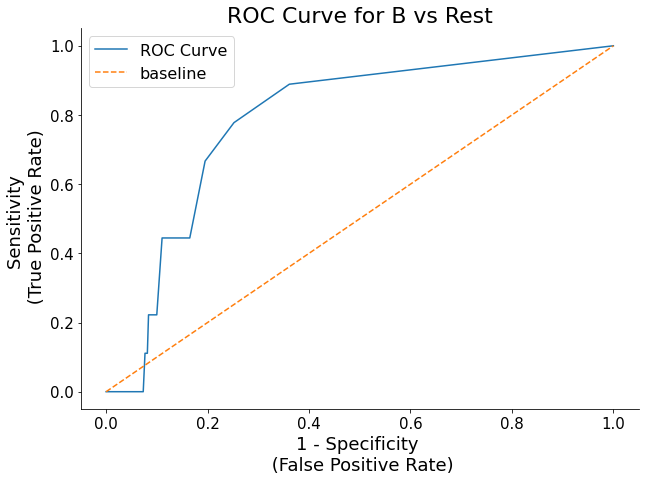

In [702]:
ovr_roc_curve(results, 'y_isB', 'B')

The reason our ROC curve for class B looks quite jagged is because we only have 9 observations in our validation set, hence our Recall/Sensitivity only goes up in 0.11 increments. However, this curve still looks miles better than the one we plotted earlier.

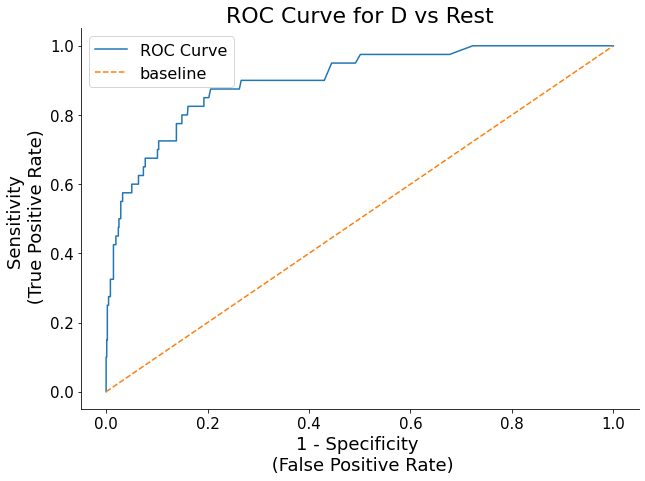

In [542]:
ovr_roc_curve(results, 'y_isD', 'D')

At 0.94 ROC AUC for class D, we're able to quite reliably discriminate between Distracted Attention states and others. This is actually our most 'undesirable' state in a sense, as it is much harder for a pilot to realise that he is distracted, than it is for him to realise that he is startled. Take distracted driving as an analogy. A driver could be talking on a phone while still thinking that he has full awareness of his driving situation. However, if the driver suddenly had to swerve because of cat dashing across the road, he would be fully aware that he was startled by the cat. As such, it is more useful to predict a state of distractedness than it is to predict a state of surprise.

In [626]:
# save our best model
pickle.dump(lgbm_clf3, open('./data/lgbmclf3.pickle', 'wb'))

### Dropping abs_energy from features

Earlier in our EDA, we saw that abs_energy had high correlation with signal variance. To see whether leaving both features in helps our model performance, we'll drop absolute energy as it is a derivative of signal variance, and observe our model performance.

In [29]:
y3 = agg_table2['event']
X3 = agg_table2.drop(columns=['event', 'is_B', 'is_D']).drop(columns=agg_table2.columns[agg_table2.columns.str.contains('abs_energy')])
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, random_state = 42, stratify = y3)

In [30]:
ss = StandardScaler()
X3train_sc = ss.fit_transform(X3_train)
X3val_sc = ss.transform(X3_val)

adasyn = ADASYN(random_state=42, n_neighbors=5, sampling_strategy={'B':150, 'D':200})
sm = SMOTE(random_state=42)
X3_res, y3_res = adasyn.fit_resample(X3train_sc, y3_train)

In [31]:
lgbm_clf4 = lgbm.LGBMClassifier(objective='multiclass',
                                num_class=4,
                                max_depth=9,
#                                subsample=0.1,
                                learning_rate=0.3,
                                n_estimators=1000,
                                reg_alpha=0,
                                reg_lambda=0.7,
                                min_child_samples=25,
                                num_leaves=16,
#                                feature_fraction=0.9,
                                bagging_seed=42,
#                                bagging_fraction=0.8,
                                extra_trees=True,
                                random_state=42)
lgbm_clf4.fit(X3_res, y3_res, 
             eval_set=[(X3val_sc, y3_val)], 
             eval_metric='multi_logloss', 
             early_stopping_rounds=100
             )

[1]	valid_0's multi_logloss: 0.814443
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.754523
[3]	valid_0's multi_logloss: 0.696479
[4]	valid_0's multi_logloss: 0.654699
[5]	valid_0's multi_logloss: 0.620023
[6]	valid_0's multi_logloss: 0.585101
[7]	valid_0's multi_logloss: 0.563813
[8]	valid_0's multi_logloss: 0.546063
[9]	valid_0's multi_logloss: 0.519905
[10]	valid_0's multi_logloss: 0.497614
[11]	valid_0's multi_logloss: 0.480835
[12]	valid_0's multi_logloss: 0.465525
[13]	valid_0's multi_logloss: 0.455351
[14]	valid_0's multi_logloss: 0.449519
[15]	valid_0's multi_logloss: 0.438701
[16]	valid_0's multi_logloss: 0.432593
[17]	valid_0's multi_logloss: 0.420515
[18]	valid_0's multi_logloss: 0.413389
[19]	valid_0's multi_logloss: 0.407278
[20]	valid_0's multi_logloss: 0.398019
[21]	valid_0's multi_logloss: 0.39449
[22]	valid_0's multi_logloss: 0.389124
[23]	valid_0's multi_logloss: 0.385817
[24]	valid_0's multi_logloss: 0.381422
[25]	valid_0

LGBMClassifier(bagging_seed=42, extra_trees=True, learning_rate=0.3,
               max_depth=9, min_child_samples=25, n_estimators=1000,
               num_class=4, num_leaves=16, objective='multiclass',
               random_state=42, reg_alpha=0, reg_lambda=0.7)

In [32]:
probas = lgbm_clf4.predict_proba(X3val_sc)
preds = lgbm_clf4.predict(X3val_sc)
results = pd.DataFrame(probas, columns=lgbm_clf4.classes_)
results['y_true'] = y3_val.reset_index(drop=True)
results['y_preds'] = preds
individual_ovr_roc_score(results)
display(roc_auc_score(y3_res, lgbm_clf4.predict_proba(X3_res), multi_class='ovr', average='macro'))
roc_auc_score(y3_val, probas, multi_class='ovr', average='macro')

OvR AUROC for A vs rest: 0.9638898684388987
OvR AUROC for B vs rest: 0.8022970705897534
OvR AUROC for C vs rest: 0.9833946442443906
OvR AUROC for D vs rest: 0.9310240963855422


1.0

0.9201514199146461

We see that scores actually dropped slightly when we removed abs_energy, so we will keep all our features in for now, in line with what we saw in our literature review.

### Exploring feature importance of LGBM

Now that we have our best model, we can take a look at what features our model considered to be important. 

<AxesSubplot:xlabel='importance'>

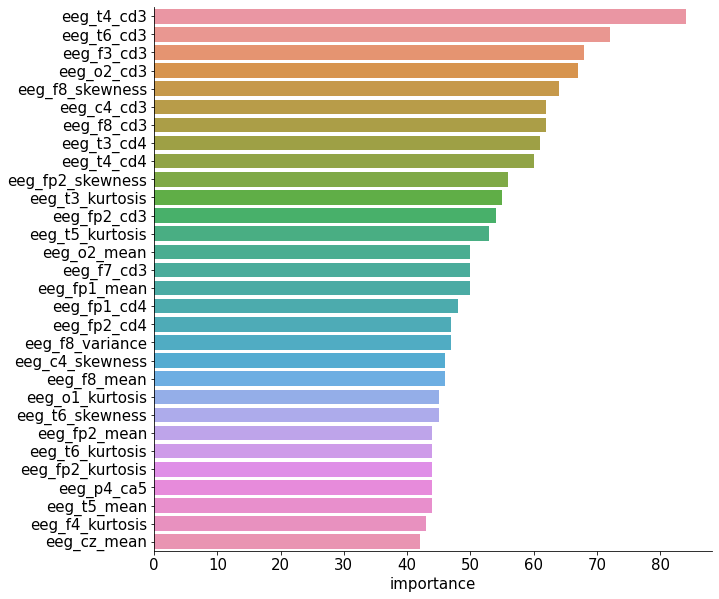

In [26]:
f_imp = pd.DataFrame(lgbm_clf3.feature_importances_,
                     columns=['importance'],
                     index=X_val.columns)
f_imp.sort_values(by='importance', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=f_imp.iloc[:30], y=f_imp.iloc[:30].index, x = 'importance', orient='h' )

Based on our model, we see that some of the most important features are the total energy we extracted from the cD3 and cD4 coefficients. Recall that the cD3 coefficients correspond to the frequency band of 32-64 Hz, and the cD4 coefficients correspond to the frequency band of 16-32 Hz. Loosely speaking, the cD3 coefficients captures the range of brain waves referred to as Gamma waves (generally waves above 30Hz), which have been linked to states of [deep concentration, problem-solving](https://www.healthline.com/health/gamma-brain-waves#what-are-they) and [high-level information processing](https://nhahealth.com/brainwaves-the-language/). Compared to the other brain waves, gamma waves have the fastest activity. If we recall from our EDA the boxplots for the cD3 energy for each EEG channel, we realise that this band is the band where the CD3 energy for class D, Distracted Attention, is much lower than that of other classes. If gamma wave activity modulates concentration and information processing, then a distraction event would disrupt this gamma wave activity, making them less dominant. Recall also that gamma waves are responsible for propagating novel stimuli about unexpected events, which could help to distinguish class B events from the rest. This could explain why our model found cD3 energy features to be important predictors.

cD4 coefficients correspond to Beta brain waves, more specifically the mid to high range of Beta waves. These beta waves are dominant when a person is [alert and engaged](https://www.scientificamerican.com/article/what-is-the-function-of-t-1997-12-22/). Because there exists some discrepencies in how some researchers have defined the range of beta and gamma waves, high beta waves can be considered to overlap with low gamma waves. This is why high beta waves are also linked to states of concentration. 

Apart from the cD3 and cD4 energy, we also see that the higher order moments, kurtosis and skew, also feature heavily in the top 30 predictors. Although the research papers I have read do not explain why these statistics are useful features, the fact is that the use of these features are often proposed, and our model has agreed with these papers that kurtosis and skew are useful features to extract from EEG signals.

## Next steps

We've covered the first part of the project, which is to build a traditional boosted tree classifier trained on extracted features from signals. The usage of extracted features is well documented in literature and has the benefit of being much less data heavy than using raw signals, as each signal can be boiled down to a set of summary stats and engineered features. In our case, our signal chunks were 1280 samples long, but we convert them into 1 observation of 9 features each. The downside is that such an approach requires significantly more data preprocessing, and more crucially, requires extensive domain knowledge in order to know what are the appropriate features to extract for each type of signal. For example, the usage of approximate and detailed coefficients to calculate relative energy is specific to EEG signals because it is well established that EEG signals can be separated into distinct brain waves, ranging from theta all the way to gamma. Such an approach cannot be directly mapped on to other signals.

In the next notebook, we will explore using the raw signal vectors as inputs to deep learning models, namely CNNs. The usage of CNNs in the classification of multivariate time series data is also well-documented, and we will be comparing the performance of these CNNs trained on signal vectors to the performance of the LGBM model trained on extracted features.

## Import Tensorflow 
Some of the code below is required to set up tensorflow to use the GPU backend properly

In [95]:
from sklearn.utils import class_weight as class_weighter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, Conv1D, Dropout,
                                     BatchNormalization, Concatenate, GlobalAveragePooling1D, Masking, LSTM, Permute,
                                     Activation, Reshape, multiply, concatenate)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras import layers
from tensorflow import keras

import tensorflow as tf

In [96]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

gpus= tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## MTEX CNN with raw signals

The MTEX-CNN is an architecture proposed in the paper [MTEX-CNN: Multivariate Time series EXplanations for Predictions with
Convolutional Neural Networks](https://www.researchgate.net/publication/338940384_MTEX-CNN_Multivariate_Time_Series_EXplanations_for_Predictions_with_Convolutional_Neural_Networks) by R. Assaf et al. (2019). The main innovation in this model is the usage of a layer called the grad-CAM layer, or Gradient Class-Activation Mapping. Think of a heatmap that shows which parts of an image are the most important in model training. However, for our purposes, we are adopting the architecture to perform the classification aspect of this, as I was not able to find out how the grad-CAM layer is implemented. 

The MTEX-CNN is a sequential series of Conv2D and Conv1D layers. According to the authors, the architecture can be adapted to add in any number of Conv2D or Conv1D layers as required. The Conv2D layer is responsible for learning the contributions of individual features (our EEG channels), while the Conv1D layer is responsible for learning time-related interactions. Finally, the output of the last Conv1D layer is flattened and fed into a series of dense layers, with the final dense layer having a softmax activation.

<img src='./images/mtex_architecture.png' style='width: 800px'>

Starting with this model, we will revert to using our original dataset of the raw EEG signals. This will provide us a way to compare the performance of training models on extracted features vs training models on raw signals. We've already seen that the LGBM can do quite well by training on extracted features, but these features ultimately come from the raw signals, so it will be interesting to note how these CNNs perform.

In [98]:
with open('./data/df_eda_pt1.pickle', 'rb') as file:
    df = pickle.load(file)

In [101]:
# drop the unneeded rows
df.dropna(subset=['chunk'], inplace=True)

In [102]:
# from earlier, we have the indices for the class B chunks we want to drop
df = df[~df['chunk'].isin(new_list)]

In [111]:
# each input to the model is a vector, but our output is just a scalar. this code gives us scalar true values for y.
signal_y = df.groupby('chunk')['event'].max().to_numpy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4520960 entries, 2560 to 4867260
Data columns (total 33 columns):
 #   Column        Dtype  
---  ------        -----  
 0   crew          int64  
 1   experiment    object 
 2   time          float64
 3   seat          int64  
 4   eeg_fp1       float64
 5   eeg_f7        float64
 6   eeg_f8        float64
 7   eeg_t4        float64
 8   eeg_t6        float64
 9   eeg_t5        float64
 10  eeg_t3        float64
 11  eeg_fp2       float64
 12  eeg_o1        float64
 13  eeg_p3        float64
 14  eeg_pz        float64
 15  eeg_f3        float64
 16  eeg_fz        float64
 17  eeg_f4        float64
 18  eeg_c4        float64
 19  eeg_p4        float64
 20  eeg_poz       float64
 21  eeg_c3        float64
 22  eeg_cz        float64
 23  eeg_o2        float64
 24  ecg           float64
 25  r             float64
 26  gsr           float64
 27  event         object 
 28  pilot         object 
 29  ecg_denoised  float64
 30  chunk         f

In [112]:
# we are creating an X where each input is of shape (1280,21)
signal_x = df.drop(columns=['crew','seat','pilot','event','time','ecg','ecg_denoised','rsp_rate','r','gsr',
                            'experiment','chunk']).to_numpy().reshape(signal_y.shape[0], 1280, 21)

In [113]:
signalX_train, signalX_val, signaly_train, signaly_val = train_test_split(signal_x, signal_y, stratify=signal_y, random_state=42)

Base code for scaling signal vectors taken from https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix, adapted to fit my data shape.

In [114]:
# for each EEG channel we need to individually scale them
scalers = {}

# for each feature
for i in range(signalX_train.shape[2]):
    # instantiate a unique scaler
    scalers[i] = StandardScaler()
    # scale data inplace
    signalX_train[:,:,i] = scalers[i].fit_transform(signalX_train[:,:,i])
    
for i in range(signalX_val.shape[2]):
    signalX_val[:,:,i] = scalers[i].transform(signalX_val[:,:,i])


In [117]:
signalX_train.shape

(2608, 1280, 21)

In [108]:
# in order to feed our signals into the MTEX, we need the input shape to be 3 dimensional.
# thus we shape it as (n_timesteps, width, n_channels)
signalX_train = signalX_train.reshape(signalX_train.shape[0], 1280, 1, 21)
signalX_val = signalX_val.reshape(signalX_val.shape[0], 1280, 1, 21)

In [116]:
# we have to one hot encode our target variable as we are outputting 4 probabilities at the final dense layer with 4 neurons
oh_enc = OneHotEncoder(categories='auto', sparse=False)
signaly_train = oh_enc.fit_transform(signaly_train.reshape(-1,1))
signaly_val = oh_enc.transform(signaly_val.reshape(-1,1))

MTEX CNN architecture implemented in 2007, Assaf.

### Building the MTEX as described in the paper

In [62]:
mtex_cnn = Sequential()

# for the Conv2D layers, the strides are fixed as (2,1)
# the kernel size of (8,1) for the first Conv2D layer was used in the paper.
mtex_cnn.add(Conv2D(
    64, 
    activation='relu', 
    kernel_size=(8,1), 
    strides = (2,1), 
    input_shape = (1280, 1, 21), 
    padding='same')
            )

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn.add(Dropout(0.4))

# for the 2nd Conv2D layer, kernel_size = (6,1) was used in the paper
mtex_cnn.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(6,1), 
    strides = (2,1), 
    padding='same'))

mtex_cnn.add(Dropout(0.4))

# this is the 1x1 convulational layer at the end of the Conv2D layers, that uses the same number of filters as the previous layer
mtex_cnn.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(1,1), 
    strides = (1,1), 
    padding='same'))

mtex_cnn.add(Dropout(0.4))

# for this layer, we use kernel_size = (4) and strides = 2, as used in the paper

mtex_cnn.add(Conv1D(
    128, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

mtex_cnn.add(Flatten())

# after flattening, the output is connected to a series of Dense layers with a final softmax activation
# this layer also utilizes L2 regularization of 0.2.
mtex_cnn.add(Dense(
    128, 
    activation = 'relu',
    bias_regularizer=tf.keras.regularizers.L2(0.2)
)
            )

mtex_cnn.add(Dense(
    4, 
    activation = 'softmax')
            )

#Compile the network

opt = keras.optimizers.Adam(learning_rate=0.001)
mtex_cnn.compile(
    loss='categorical_crossentropy', 
    optimizer=opt, 
    metrics=['acc'])

In [63]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_mtex_3.1.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [137]:
mtex_cnn.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 640, 1, 64)        10816     
_________________________________________________________________
dropout_39 (Dropout)         (None, 640, 1, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 320, 1, 128)       49280     
_________________________________________________________________
dropout_40 (Dropout)         (None, 320, 1, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 320, 1, 128)       16512     
_________________________________________________________________
dropout_41 (Dropout)         (None, 320, 1, 128)       0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 320, 1, 128)     

In [104]:
history_mtex = mtex_cnn.fit(
    signalX_train, 
    signaly_train, 
    validation_data=(signalX_val, signaly_val),
    epochs=1000, 
    batch_size=64,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
42/42 [==============================] - 5s 111ms/step - loss: 1.4135 - acc: 0.4954 - val_loss: 1.0062 - val_acc: 0.4723
Epoch 2/1000
42/42 [==============================] - 4s 105ms/step - loss: 0.9085 - acc: 0.5673 - val_loss: 0.9668 - val_acc: 0.4168
Epoch 3/1000
42/42 [==============================] - 4s 105ms/step - loss: 0.9053 - acc: 0.5794 - val_loss: 0.8808 - val_acc: 0.5968
Epoch 4/1000
42/42 [==============================] - 4s 106ms/step - loss: 0.8415 - acc: 0.5868 - val_loss: 0.8510 - val_acc: 0.6149
Epoch 5/1000
42/42 [==============================] - 4s 105ms/step - loss: 0.7542 - acc: 0.6781 - val_loss: 0.9189 - val_acc: 0.5629
Epoch 6/1000
42/42 [==============================] - 4s 105ms/step - loss: 0.7312 - acc: 0.6836 - val_loss: 0.6627 - val_acc: 0.7667
Epoch 7/1000
42/42 [==============================] - 4s 105ms/step - loss: 0.6089 - acc: 0.7711 - val_loss: 0.7230 - val_acc: 0.7078
Epoch 8/1000
42/42 [==============================] - 4s 106ms

In [105]:
mtex_1 = keras.models.load_model('./keras_checkpoints/best_mtex_3.1.h5')

In [106]:
probas = mtex_1.predict(signalX_val)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, mtex_cnn.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.8929784410237117
OvR AUROC for B vs rest: 0.796484003801077
OvR AUROC for C vs rest: 0.9376609680284191
OvR AUROC for D vs rest: 0.9010379596678529
Macro AUROC: 0.8820403431302651


In [65]:
def plot_training_history(history_obj, metric_1='loss', metric_2='acc', from_csv=False):
    if from_csv:
        history_log = history_obj
    else:
        history_log = history_obj.history
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
    train_loss = history_log[metric_1]
    test_loss = history_log['val_' + metric_1]
    train_acc = history_log[metric_2]
    test_acc = history_log['val_' + metric_2]
    ax1.plot(train_loss, label = 'Training {}'.format(metric_1), color = 'navy')
    ax1.plot(test_loss, label = 'Testing {}'.format(metric_1), color = 'skyblue')
    ax1.legend()
    ax2.plot(train_acc, label = 'Training {}'.format(metric_2), color = 'navy')
    ax2.plot(test_acc, label = 'Testing {}'.format(metric_2), color = 'skyblue')
    ax2.legend()

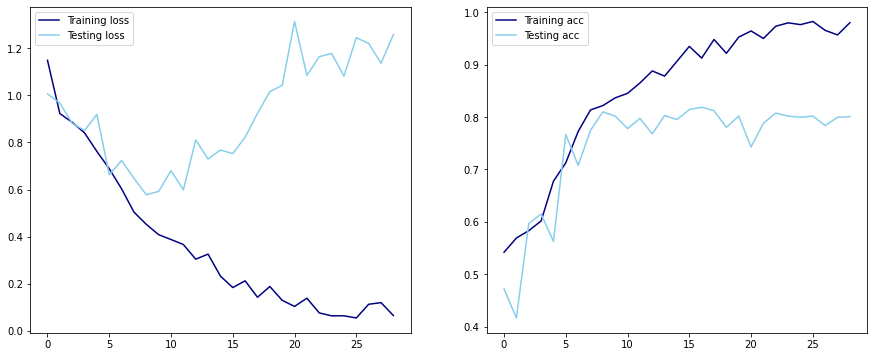

In [108]:
plot_training_history(history_mtex)

The performance of the MTEX is, sadly, not as good as I expected. This CNN beats our baseline RandomForest model but still does worse than the LGBM. We will try out some adjustments that were proposed in the paper.

### MTEX with 1 additional Conv2D layer
The authors of the MTEX paper say that the MTEX architecture can be adapted to add Conv2D or Conv1D layers as needed. We'll try this and see if our performance can improve. We start by adding 1 more Conv2D layer, with the same number of filters and kernel size as the previous layer.

In [138]:
mtex_cnn2 = Sequential()

# for the Conv2D layers, the strides are fixed as (2,1)
# the kernel size of (8,1) for the first Conv2D layer was used in the paper.
mtex_cnn2.add(Conv2D(
    64, 
    activation='relu', 
    kernel_size=(8,1), 
    strides = (2,1), 
    input_shape = (1280,1,21), 
    padding='same')
            )

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn.add(Dropout(0.4))

# for the 2nd Conv2D layer, kernel_size = (6,1) was used in the paper
mtex_cnn2.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(6,1), 
    strides = (2,1), 
    padding='same'))

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn.add(Dropout(0.4))

# adding a 3rd Conv2D layer
mtex_cnn2.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(6,1), 
    strides = (2,1), 
    padding='same'))

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn.add(Dropout(0.4))

# this is the 1x1 convulational layer at the end of the Conv2D layers, that uses the same number of filters as the previous layer
mtex_cnn2.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(1,1), 
    strides = (1,1), 
    padding='same'))

# between the Conv2D and Conv1D layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn2.add(Dropout(0.4))

# for this layer, we use kernel_size = (4) and strides = 2, as used in the paper

mtex_cnn2.add(Conv1D(
    128, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

mtex_cnn2.add(Dropout(0.4))

mtex_cnn2.add(Flatten())

# after flattening, the output is connected to a series of Dense layers with a final softmax activation
# this layer also utilizes L2 regularization of 0.2.
mtex_cnn2.add(Dense(
    128, 
    activation = 'relu',
    bias_regularizer=tf.keras.regularizers.L2(0.2)
)
            )

mtex_cnn2.add(Dense(
    4, 
    activation = 'softmax')
            )

#Compile the network
mtex_cnn2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc'])

In [139]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_mtex_3.2.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [140]:
mtex_cnn2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 640, 1, 64)        10816     
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 320, 1, 128)       49280     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 160, 1, 128)       98432     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 160, 1, 128)       16512     
_________________________________________________________________
dropout_45 (Dropout)         (None, 160, 1, 128)       0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 160, 1, 128)       65664     
_________________________________________________________________
dropout_46 (Dropout)         (None, 160, 1, 128)     

In [141]:
history_mtex2 = mtex_cnn2.fit(
    signalX_train, 
    signaly_train, 
    validation_data=(signalX_val, signaly_val),
    epochs=1000, 
    batch_size=64,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
42/42 [==============================] - 2s 39ms/step - loss: 1.0439 - acc: 0.5310 - val_loss: 0.9168 - val_acc: 0.5617
Epoch 2/1000
42/42 [==============================] - 1s 32ms/step - loss: 0.9051 - acc: 0.5732 - val_loss: 0.9040 - val_acc: 0.5402
Epoch 3/1000
42/42 [==============================] - 1s 32ms/step - loss: 0.8297 - acc: 0.5976 - val_loss: 0.8531 - val_acc: 0.6297
Epoch 4/1000
42/42 [==============================] - 1s 32ms/step - loss: 0.7502 - acc: 0.6725 - val_loss: 0.8361 - val_acc: 0.6433
Epoch 5/1000
42/42 [==============================] - 1s 32ms/step - loss: 0.6561 - acc: 0.7061 - val_loss: 0.6905 - val_acc: 0.7622
Epoch 6/1000
42/42 [==============================] - 1s 32ms/step - loss: 0.4751 - acc: 0.8247 - val_loss: 0.6969 - val_acc: 0.7576
Epoch 7/1000
42/42 [==============================] - 1s 32ms/step - loss: 0.4285 - acc: 0.8388 - val_loss: 0.5794 - val_acc: 0.8041
Epoch 8/1000
42/42 [==============================] - 1s 31ms/step - 

In [142]:
mtex_2 = keras.models.load_model('./keras_checkpoints/best_mtex_3.2.h5')

In [143]:
probas = mtex_2.predict(signalX_val)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, mtex_cnn.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.88306110292504
OvR AUROC for B vs rest: 0.6924295216978145
OvR AUROC for C vs rest: 0.932188055062167
OvR AUROC for D vs rest: 0.9084519572953736
Macro AUROC: 0.8540326592450987


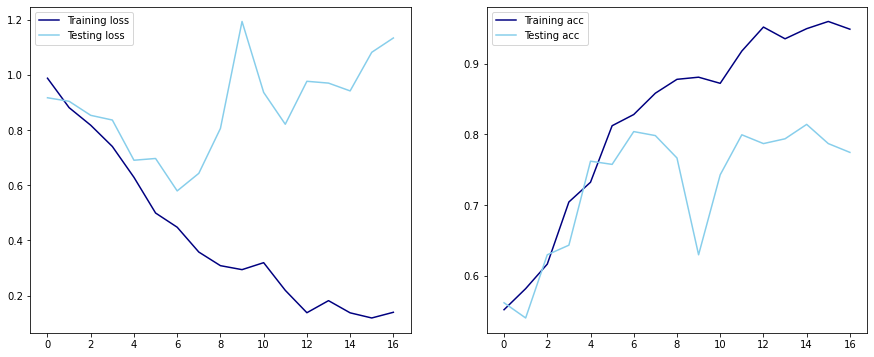

In [144]:
plot_training_history(history_mtex2)

Our second run with an additional Conv2D layer does worse. The additional Conv2D layer reduced our time dimension by another factor of 2, and perhaps we lost too much information here. Our validation loss still very quickly deteriorates instead of converging as well. We'll try one more architecture using an additional Conv1D layer instead of the Conv2D layer. One additional tweak to the architecture I want to make is to remove the 1x1 convolutional layer in the middle, because I feel that I'm not able to implement as intended in the paper.

### MTEX with 1 additional Conv1D layer

In [145]:
mtex_cnn3 = Sequential()

# for the Conv2D layers, the strides are fixed as (2,1)
# the kernel size of (8,1) for the first Conv2D layer was used in the paper.
mtex_cnn3.add(Conv2D(
    64, 
    activation='relu', 
    kernel_size=(8,1), 
    strides = (2,1), 
    input_shape = (1280,1,21), 
    padding='same')
            )

mtex_cnn3.add(Dropout(0.4))

# for the 2nd Conv2D layer, kernel_size = (6,1) was used in the paper
mtex_cnn3.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(6,1), 
    strides = (2,1), 
    padding='same'))


# between the Conv2D and Conv1D layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn3.add(Dropout(0.4))


# for this layer, we use kernel_size = (4) and strides = 2, as used in the paper

mtex_cnn3.add(Conv1D(
    128, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

mtex_cnn3.add(Dropout(0.4))

mtex_cnn3.add(Conv1D(
    64, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

mtex_cnn3.add(Dropout(0.4))

mtex_cnn3.add(Flatten())

# after flattening, the output is connected to a series of Dense layers with a final softmax activation
# this layer also utilizes L2 regularization of 0.2.
mtex_cnn3.add(Dense(
    128, 
    activation = 'relu',
    bias_regularizer=tf.keras.regularizers.L2(0.2)
)
            )

mtex_cnn3.add(Dense(
    4, 
    activation = 'softmax')
            )

#Compile the network
mtex_cnn3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc'])

In [146]:
mtex_cnn3.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 640, 1, 64)        10816     
_________________________________________________________________
dropout_47 (Dropout)         (None, 640, 1, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 320, 1, 128)       49280     
_________________________________________________________________
dropout_48 (Dropout)         (None, 320, 1, 128)       0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 320, 1, 128)       65664     
_________________________________________________________________
dropout_49 (Dropout)         (None, 320, 1, 128)       0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 320, 1, 64)      

In [147]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_mtex_3.3.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [148]:
history_mtex3 = mtex_cnn3.fit(
    signalX_train, 
    signaly_train, 
    validation_data=(signalX_val, signaly_val),
    epochs=1000, 
    batch_size=64,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
42/42 [==============================] - 6s 117ms/step - loss: 1.0666 - acc: 0.5481 - val_loss: 0.9617 - val_acc: 0.5674
Epoch 2/1000
42/42 [==============================] - 5s 109ms/step - loss: 0.9084 - acc: 0.5722 - val_loss: 0.9931 - val_acc: 0.4190
Epoch 3/1000
42/42 [==============================] - 5s 110ms/step - loss: 0.8722 - acc: 0.5576 - val_loss: 0.8477 - val_acc: 0.6308
Epoch 4/1000
42/42 [==============================] - 5s 110ms/step - loss: 0.8317 - acc: 0.6394 - val_loss: 0.8594 - val_acc: 0.5991
Epoch 5/1000
42/42 [==============================] - 5s 110ms/step - loss: 0.7941 - acc: 0.6397 - val_loss: 0.7326 - val_acc: 0.7350
Epoch 6/1000
42/42 [==============================] - 5s 112ms/step - loss: 0.6556 - acc: 0.7487 - val_loss: 0.6931 - val_acc: 0.7361
Epoch 7/1000
42/42 [==============================] - 5s 113ms/step - loss: 0.5854 - acc: 0.7495 - val_loss: 0.6750 - val_acc: 0.7724
Epoch 8/1000
42/42 [==============================] - 5s 109ms

In [149]:
mtex_3 = keras.models.load_model('./keras_checkpoints/best_mtex_3.3.h5')

In [150]:
probas = mtex_3.predict(signalX_val)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, mtex_cnn.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.8899165020743852
OvR AUROC for B vs rest: 0.7666561081195228
OvR AUROC for C vs rest: 0.9286578596802842
OvR AUROC for D vs rest: 0.922894424673784
Macro AUROC: 0.877031223636994


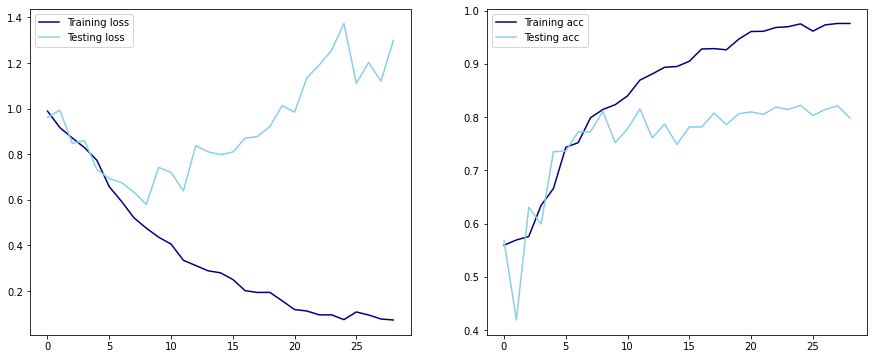

In [151]:
plot_training_history(history_mtex3)

Our scores have improved from the previous model, although we are still quite a ways off from matching the performance of our LGBM. The additional Conv1D layer seems to work better than the Conv2D layer, so we'll try just 1 more architecture, this time with 2 additional Conv1D layers. However, judging from the validation loss, I suspect we are hitting the limits of what this model can give us.

### MTEX with 2 additional Conv1D layers

In [152]:
mtex_cnn4 = Sequential()

# for the Conv2D layers, the strides are fixed as (2,1)
# the kernel size of (8,1) for the first Conv2D layer was used in the paper.
mtex_cnn4.add(Conv2D(
    64, 
    activation='relu', 
    kernel_size=(8,1), 
    strides = (2,1), 
    input_shape = (1280,1,21), 
    padding='same')
            )

# between the Conv2D and Conv1D layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn4.add(Dropout(0.4))

# for the 2nd Conv2D layer, kernel_size = (6,1) was used in the paper
mtex_cnn4.add(Conv2D(
    128, 
    activation='relu', 
    kernel_size=(6,1), 
    strides = (2,1), 
    padding='same'))

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn4.add(Dropout(0.4))

# for this layer, we use kernel_size = (4) and strides = 2, as used in the paper

mtex_cnn4.add(Conv1D(
    128, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn4.add(Dropout(0.4))

mtex_cnn4.add(Conv1D(
    64, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

# between each layer, a Dropout layer is added with a dropout ratio of 0.4
mtex_cnn4.add(Dropout(0.4))

mtex_cnn4.add(Conv1D(
    32, 
    activation='relu', 
    strides = 2, 
    kernel_size=4, 
    padding='same'))

mtex_cnn4.add(Dropout(0.4))

mtex_cnn4.add(Flatten())

# after flattening, the output is connected to a series of Dense layers with a final softmax activation
# this layer also utilizes L2 regularization of 0.2.
mtex_cnn4.add(Dense(
    128, 
    activation = 'relu',
    bias_regularizer=tf.keras.regularizers.L2(0.2)
)
            )

mtex_cnn4.add(Dense(
    4, 
    activation = 'softmax')
            )

#Compile the network
mtex_cnn4.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc'])

In [153]:
mtex_cnn4.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 640, 1, 64)        10816     
_________________________________________________________________
dropout_51 (Dropout)         (None, 640, 1, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 320, 1, 128)       49280     
_________________________________________________________________
dropout_52 (Dropout)         (None, 320, 1, 128)       0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 320, 1, 128)       65664     
_________________________________________________________________
dropout_53 (Dropout)         (None, 320, 1, 128)       0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 320, 1, 64)      

In [154]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_mtex_3.4.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [155]:
history_mtex4 = mtex_cnn4.fit(
    signalX_train, 
    signaly_train, 
    validation_data=(signalX_val, signaly_val),
    epochs=1000, 
    batch_size=64,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
42/42 [==============================] - 7s 139ms/step - loss: 1.0288 - acc: 0.5315 - val_loss: 0.9218 - val_acc: 0.5674
Epoch 2/1000
42/42 [==============================] - 6s 133ms/step - loss: 0.9211 - acc: 0.5505 - val_loss: 0.9006 - val_acc: 0.5674
Epoch 3/1000
42/42 [==============================] - 6s 132ms/step - loss: 0.9182 - acc: 0.5512 - val_loss: 0.9062 - val_acc: 0.5311
Epoch 4/1000
42/42 [==============================] - 5s 131ms/step - loss: 0.8805 - acc: 0.5968 - val_loss: 0.8488 - val_acc: 0.6138
Epoch 5/1000
42/42 [==============================] - 6s 131ms/step - loss: 0.8395 - acc: 0.6300 - val_loss: 0.8799 - val_acc: 0.5572
Epoch 6/1000
42/42 [==============================] - 6s 131ms/step - loss: 0.7485 - acc: 0.6834 - val_loss: 0.8170 - val_acc: 0.6897
Epoch 7/1000
42/42 [==============================] - 6s 132ms/step - loss: 0.6725 - acc: 0.7471 - val_loss: 0.6448 - val_acc: 0.7905
Epoch 8/1000
42/42 [==============================] - 5s 130ms

In [156]:
mtex_4 = keras.models.load_model('./keras_checkpoints/best_mtex_3.4.h5')

In [157]:
probas = mtex_4.predict(signalX_val)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, mtex_cnn.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.8965106436341976
OvR AUROC for B vs rest: 0.748917748917749
OvR AUROC for C vs rest: 0.937516651865009
OvR AUROC for D vs rest: 0.9073250296559905
Macro AUROC: 0.8725675185182364


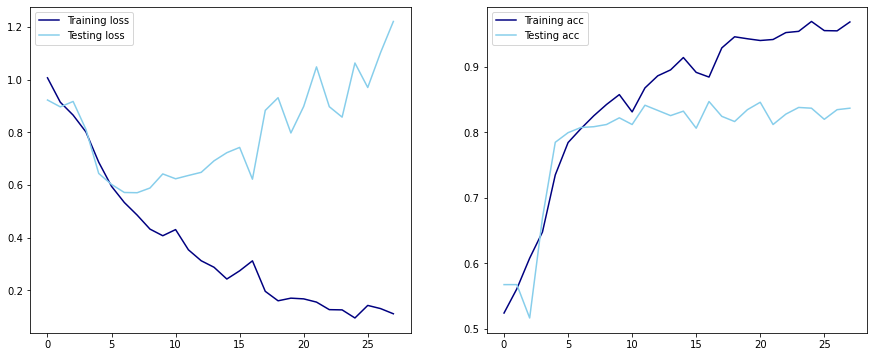

In [77]:
plot_training_history(history_mtex4)

The additional Conv1D hasn't done anything for our model performance. The main issue is that regardless of the architecture, our validation does not converge, and in fact diverges away.

Sometimes, it is better to decide that there is little utility remaining in trying to improve something, and instead quickly move on to a more promising solution. I believe that this is one of those times, especially considering that we already have an LGBM model that performs way better than this. Part of the reason why I think this model did not perform so well is because I was unable to properly implement it according to the paper. In particular, I had trouble with the 1x1 convolutional layer.


## XCM 
While researching the MTEX-CNN, I came across another paper that proposed a new architecture called the XCM - Explainable Convolutional Neural Network for Multivariate Time Series Classiﬁcation. This paper reviewed a few different existing models for multivariate time series classification, and one of these models was the MTEX-CNN that we tried before. The authors compared their own XCM against these existing models and found that it performed better than them. The unique point of this architecture is its use of 2 concurrent convolutional layers. The first is a Conv2D layer that learns information about the features we feed to the model. In our case, these are the different EEG channels. The second is a Conv1D layer that learns time-relative information, as opposed to feature-relative information. These 2 layers are then concatenated and passed through a global average pooling layer before being output to a final dense layer with softmax activation. Compared to the MTEX-CNN, the global average pooling layer here is supposed to help prevent trainable params from exploding. With the MTEX-CNN, there is a risk of trainable params becoming untenable due to the fully connected dense layers.

<img src="./images/xcm_architecture.png" style="width: 800px;"/>

The authors have also specified some of the hyperparameters that they used. As this model is not trivial, it is better to follow their example first. In particular, these are their suggestions:

1. filters = 128
2. kernel_size = window size.
    - window size here is a percentage of the total number of time steps taken. In the paper, the authors gridsearched over this hyperparameter, but we will start ours at 20% of 1280 (our input length), or 256.
3. strides = 1
4. padding = 'same'

In [118]:
X2d_train = signalX_train.reshape(signalX_train.shape[0], 1280, 21, 1)
X1d_train = signalX_train.reshape(signalX_train.shape[0], 1280, 1, 21)

X2d_val = signalX_val.reshape(signalX_val.shape[0], 1280, 21, 1)
X1d_val = signalX_val.reshape(signalX_val.shape[0], 1280, 1, 21)

### XCM - default params

In [84]:
inputs_2D = keras.Input(shape=(1280,21,1), name = '2d')
inputs_1D = keras.Input(shape=(1280,1,21), name = '1d')

conv_2D_layer = layers.Conv2D(filters=128,
                              kernel_size=(256,1),
                              padding='same',
                              strides=(1,1),
                              activation='relu',
                              )(inputs_2D)

conv_2D_layer = layers.BatchNormalization()(conv_2D_layer)

conv_2D_layer = layers.Conv2D(filters=1,
                              kernel_size=(1,1),
                              padding='same',
                              strides=(1,1),
                              activation='relu',
                              )(conv_2D_layer)

# layer_2D = keras.Model(inputs_2D, conv_2D_layer)

conv_1D_layer = layers.Conv1D(filters=128,
                              kernel_size=(256),
                              padding='same',
                              strides=1,
                              activation='relu')(inputs_1D)

conv_1D_layer = layers.BatchNormalization()(conv_1D_layer)

conv_1D_layer = layers.Conv1D(filters=1,
                              kernel_size=1,
                              padding='same',
                              strides=1,
                              activation='relu')(conv_1D_layer)

# layer_1D = keras.Model(inputs_1D, conv_1D_layer)

combined = layers.Concatenate(axis=2)([conv_2D_layer, conv_1D_layer])

combined = layers.Conv1D(filters=128,
                         kernel_size=256,
                         padding='same',
                         strides=1,
                         activation='relu')(combined)

combined = layers.BatchNormalization()(combined)

combined = layers.GlobalAveragePooling2D()(combined)

combined = layers.Dense(4, activation='softmax')(combined)

xcm_1 = keras.Model(inputs = [inputs_2D, inputs_1D], outputs=[combined])

xcm_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=50, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_xcm_(256,1).h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [79]:
model_4.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
2d (InputLayer)                 [(None, 1280, 21, 1) 0                                            
__________________________________________________________________________________________________
1d (InputLayer)                 [(None, 1280, 1, 21) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 1280, 21, 128 32896       2d[0][0]                         
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 1280, 1, 128) 688256      1d[0][0]                         
___________________________________________________________________________________________

In [85]:
history_xcm1 = xcm_1.fit(
    {'2d': X2d_train,
     '1d': X1d_train},
    signaly_train, 
    validation_data=([X2d_val, X1d_val], signaly_val),
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stop]
    )

Epoch 1/1000
82/82 [==============================] - 106s 1s/step - loss: 1.2197 - acc: 0.5146 - val_loss: 0.9390 - val_acc: 0.5759
Epoch 2/1000
82/82 [==============================] - 87s 1s/step - loss: 0.7820 - acc: 0.6946 - val_loss: 0.8449 - val_acc: 0.5759
Epoch 3/1000
82/82 [==============================] - 87s 1s/step - loss: 0.6493 - acc: 0.7608 - val_loss: 0.8103 - val_acc: 0.7540
Epoch 4/1000
82/82 [==============================] - 87s 1s/step - loss: 0.5618 - acc: 0.8059 - val_loss: 0.8267 - val_acc: 0.5828
Epoch 5/1000
82/82 [==============================] - 88s 1s/step - loss: 0.5803 - acc: 0.7962 - val_loss: 0.6636 - val_acc: 0.7529
Epoch 6/1000
82/82 [==============================] - 88s 1s/step - loss: 0.5590 - acc: 0.8018 - val_loss: 0.6579 - val_acc: 0.7747
Epoch 7/1000
82/82 [==============================] - 88s 1s/step - loss: 0.5268 - acc: 0.8214 - val_loss: 0.8880 - val_acc: 0.5678
Epoch 8/1000
82/82 [==============================] - 88s 1s/step - loss: 0

82/82 [==============================] - 86s 1s/step - loss: 0.3086 - acc: 0.8906 - val_loss: 0.5118 - val_acc: 0.8069
Epoch 63/1000
82/82 [==============================] - 86s 1s/step - loss: 0.3221 - acc: 0.8903 - val_loss: 0.4331 - val_acc: 0.8552
Epoch 64/1000
82/82 [==============================] - 86s 1s/step - loss: 0.3288 - acc: 0.8879 - val_loss: 0.8183 - val_acc: 0.7115
Epoch 65/1000
82/82 [==============================] - 86s 1s/step - loss: 0.3282 - acc: 0.8879 - val_loss: 0.6596 - val_acc: 0.7563
Epoch 66/1000
82/82 [==============================] - 85s 1s/step - loss: 0.3257 - acc: 0.8920 - val_loss: 0.6835 - val_acc: 0.7736
Epoch 67/1000
82/82 [==============================] - 85s 1s/step - loss: 0.3085 - acc: 0.9035 - val_loss: 0.5202 - val_acc: 0.8138
Epoch 68/1000
82/82 [==============================] - 86s 1s/step - loss: 0.3152 - acc: 0.8927 - val_loss: 0.5514 - val_acc: 0.8241
Epoch 69/1000
82/82 [==============================] - 86s 1s/step - loss: 0.3087 -

82/82 [==============================] - 85s 1s/step - loss: 0.2389 - acc: 0.9079 - val_loss: 0.5845 - val_acc: 0.8345
Epoch 124/1000
82/82 [==============================] - 85s 1s/step - loss: 0.2521 - acc: 0.9114 - val_loss: 0.8052 - val_acc: 0.7034
Epoch 125/1000
82/82 [==============================] - 86s 1s/step - loss: 0.2447 - acc: 0.9112 - val_loss: 0.6244 - val_acc: 0.7931
Epoch 126/1000
82/82 [==============================] - 85s 1s/step - loss: 0.2572 - acc: 0.9140 - val_loss: 0.4606 - val_acc: 0.8460
Epoch 127/1000
82/82 [==============================] - 85s 1s/step - loss: 0.2549 - acc: 0.9096 - val_loss: 0.4392 - val_acc: 0.8736
Epoch 128/1000
82/82 [==============================] - 85s 1s/step - loss: 0.2450 - acc: 0.9131 - val_loss: 0.8918 - val_acc: 0.6264
Epoch 129/1000
82/82 [==============================] - 85s 1s/step - loss: 0.2498 - acc: 0.9145 - val_loss: 0.9246 - val_acc: 0.6943
Epoch 130/1000
82/82 [==============================] - 85s 1s/step - loss: 0

82/82 [==============================] - 87s 1s/step - loss: 0.1978 - acc: 0.9309 - val_loss: 0.4843 - val_acc: 0.8460
Epoch 185/1000
82/82 [==============================] - 86s 1s/step - loss: 0.2040 - acc: 0.9292 - val_loss: 1.7241 - val_acc: 0.5552
Epoch 186/1000
82/82 [==============================] - 87s 1s/step - loss: 0.2103 - acc: 0.9246 - val_loss: 0.8188 - val_acc: 0.7598
Epoch 187/1000
82/82 [==============================] - 86s 1s/step - loss: 0.1792 - acc: 0.9391 - val_loss: 0.4909 - val_acc: 0.8471
Epoch 188/1000
82/82 [==============================] - 86s 1s/step - loss: 0.1766 - acc: 0.9380 - val_loss: 0.4591 - val_acc: 0.8391
Epoch 189/1000
82/82 [==============================] - 86s 1s/step - loss: 0.1698 - acc: 0.9451 - val_loss: 0.6547 - val_acc: 0.8023
Epoch 190/1000
82/82 [==============================] - 86s 1s/step - loss: 0.2262 - acc: 0.9256 - val_loss: 0.6516 - val_acc: 0.8034


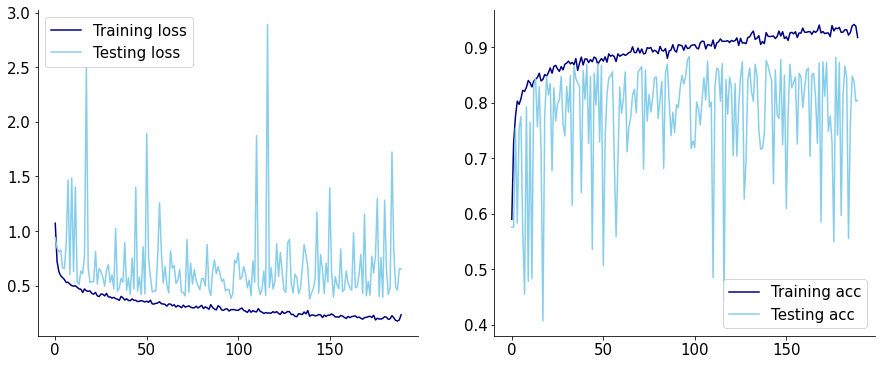

In [91]:
plot_training_history(history_xcm1)

In [89]:
probas = xcm_1.predict([X2d_val, X1d_val])
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')

OvR AUROC for A vs rest: 0.9126354337395669
OvR AUROC for B vs rest: 0.7119628339140534
OvR AUROC for C vs rest: 0.9694772727272727
OvR AUROC for D vs rest: 0.8956626506024096


0.8724345477458256

In [82]:
# history_xcm1 = xcm_1.fit(
#     {'2d': X2d_train,
#      '1d': X1d_train},
#     signaly_train, 
#     validation_data=([X2d_val, X1d_val], signaly_val),
#     epochs=1000, 
#     batch_size=32,
#     callbacks=[early_stop, model_checkpoint]
#     )

Epoch 1/1000
82/82 [==============================] - 93s 1s/step - loss: 1.2045 - acc: 0.5145 - val_loss: 0.9170 - val_acc: 0.5759
Epoch 2/1000
82/82 [==============================] - 90s 1s/step - loss: 0.7330 - acc: 0.7242 - val_loss: 0.8672 - val_acc: 0.5759
Epoch 3/1000
82/82 [==============================] - 90s 1s/step - loss: 0.6999 - acc: 0.7325 - val_loss: 0.8629 - val_acc: 0.5759
Epoch 4/1000
82/82 [==============================] - 90s 1s/step - loss: 0.6164 - acc: 0.7714 - val_loss: 0.8357 - val_acc: 0.5747
Epoch 5/1000
82/82 [==============================] - 90s 1s/step - loss: 0.5630 - acc: 0.7935 - val_loss: 0.6766 - val_acc: 0.7563
Epoch 6/1000
82/82 [==============================] - 89s 1s/step - loss: 0.5288 - acc: 0.8142 - val_loss: 0.6102 - val_acc: 0.7920
Epoch 7/1000
82/82 [==============================] - 89s 1s/step - loss: 0.5136 - acc: 0.8265 - val_loss: 0.6775 - val_acc: 0.7149
Epoch 8/1000
82/82 [==============================] - 90s 1s/step - loss: 0.

In [84]:
best_xcm_1 = keras.models.load_model('./keras_checkpoints/best_xcm_(256,1).h5')

In [85]:
probas = best_xcm_1.predict([X2d_val, X1d_val])
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')

OvR AUROC for A vs rest: 0.937409733378771
OvR AUROC for B vs rest: 0.7902955220028391
OvR AUROC for C vs rest: 0.9636363636363637
OvR AUROC for D vs rest: 0.8746686746987952


0.8915025734291923

### XCM - decreasing window size to 128

In [89]:
inputs_2D = keras.Input(shape=(1280,21,1), name = '2d')
inputs_1D = keras.Input(shape=(1280,1,21), name = '1d')

conv_2D_layer = layers.Conv2D(filters=128,
                              kernel_size=(128,1),
                              padding='same',
                              strides=(1,1),
                              activation='relu',
                              )(inputs_2D)

conv_2D_layer = layers.BatchNormalization()(conv_2D_layer)

conv_2D_layer = layers.Conv2D(filters=1,
                              kernel_size=(1,1),
                              padding='same',
                              strides=(1,1),
                              activation='relu',
                              )(conv_2D_layer)

# layer_2D = keras.Model(inputs_2D, conv_2D_layer)

conv_1D_layer = layers.Conv1D(filters=128,
                              kernel_size=(128),
                              padding='same',
                              strides=1,
                              activation='relu')(inputs_1D)

conv_1D_layer = layers.BatchNormalization()(conv_1D_layer)

conv_1D_layer = layers.Conv1D(filters=1,
                              kernel_size=1,
                              padding='same',
                              strides=1,
                              activation='relu')(conv_1D_layer)

# layer_1D = keras.Model(inputs_1D, conv_1D_layer)

combined = layers.Concatenate(axis=2)([conv_2D_layer, conv_1D_layer])

combined = layers.Conv1D(filters=128,
                         kernel_size=128,
                         padding='same',
                         strides=1,
                         activation='relu')(combined)

combined = layers.BatchNormalization()(combined)

combined = layers.GlobalAveragePooling2D()(combined)

combined = layers.Dense(4, activation='softmax')(combined)

xcm_2 = keras.Model(inputs = [inputs_2D, inputs_1D], outputs=[combined])

xcm_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=50, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_xcm_(128,1).h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [90]:
xcm_2.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
2d (InputLayer)                 [(None, 1280, 21, 1) 0                                            
__________________________________________________________________________________________________
1d (InputLayer)                 [(None, 1280, 1, 21) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 1280, 21, 128 16512       2d[0][0]                         
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 1280, 1, 128) 344192      1d[0][0]                         
___________________________________________________________________________________________

In [ ]:
history_xcm2 = xcm_2.fit(
    {'2d': X2d_train,
     '1d': X1d_train},
    signaly_train, 
    validation_data=([X2d_val, X1d_val], signaly_val),
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
82/82 [==============================] - 316s 4s/step - loss: 1.2289 - acc: 0.5280 - val_loss: 0.9596 - val_acc: 0.5621
Epoch 2/1000
82/82 [==============================] - 291s 4s/step - loss: 0.8037 - acc: 0.6896 - val_loss: 0.8685 - val_acc: 0.5759
Epoch 3/1000
82/82 [==============================] - 291s 4s/step - loss: 0.6857 - acc: 0.7430 - val_loss: 0.8767 - val_acc: 0.5747
Epoch 4/1000
82/82 [==============================] - 287s 3s/step - loss: 0.6464 - acc: 0.7657 - val_loss: 0.8411 - val_acc: 0.5759
Epoch 5/1000
82/82 [==============================] - 292s 4s/step - loss: 0.6270 - acc: 0.7765 - val_loss: 0.8253 - val_acc: 0.6402
Epoch 6/1000
82/82 [==============================] - 286s 3s/step - loss: 0.6042 - acc: 0.7795 - val_loss: 1.2708 - val_acc: 0.5759
Epoch 7/1000
82/82 [==============================] - 285s 3s/step - loss: 0.5449 - acc: 0.8272 - val_loss: 0.8241 - val_acc: 0.6506
Epoch 8/1000
82/82 [==============================] - 289s 4s/step - 

In [15]:
best_xcm_2 = keras.models.load_model('./keras_checkpoints/best_xcm_(128,1).h5')

In [18]:
probas = best_xcm_2.predict([X2d_val, X1d_val])
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')

OvR AUROC for A vs rest: 0.9183746328481249
OvR AUROC for B vs rest: 0.7739063104916764
OvR AUROC for C vs rest: 0.9585909090909093
OvR AUROC for D vs rest: 0.8869879518072289


0.8844649510594849

## Further actions required

After playing around with the hyperparameters suggested in the paper, our XCM models do not seem to be able to beat our LGBM model. The best performing iteration, using the base defaults, produces results just below that of our LGBM model. Given the complexity of the model and the time needed to train it, it is very difficult to justify the continued use of this model. Even going back to the MTEX might be a better idea, as it trains faster and thus gives us more opportunities to finetune it given the limited time we have left. 

However, we have not just yet exhausted all our available avenues for improvement. For one, we are currently only running the raw EEG signals. From our analysis of the LGBM model, we noticed that the energy calculated from the cD3 coefficients proved to have strong predictive importance. As such, we could try to isolate this frequency band and reconstruct the signal there, thereby creating 1 new feature per EEG channel for our XCM model to learn from. We will do this in the next notebook.

## Reconstructing cD3 signals

Based on our findings from our LGBM model, we found out that energy calculated from cD3 coefficients seem to be quite important. As our current attempts at training our XCM CNN model on our raw signal seems to fall slightly short of the performance of our LGBM model, we'll try to create more features for our model to learn. 

We'll extract out the cD3 coefficients and this time, reconstruct the signal in the 32-64 Hz range. Together with the raw signals, we'll feed our data back into the XCM CNN model again. This method of separating signals into different frequency bands to feed into a CNN was done in the [2016 paper by C. Potes et al., *Ensemble of Feature-Based and Deep learning-based Classifiers for Detection of Abnormal Heart sounds*](http://www.cinc.org/archives/2016/pdf/182-399.pdf). Although we won't be fully deconstructing our signal into every single frequency band, the extra information we gain from the cD3 coefficients specifically should allow our model to learn more patterns. 

([<matplotlib.lines.Line2D at 0x1c0b0094af0>],
 Text(0.5, 1.0, 'Signal from 32-64 Hz band (Gamma)'))

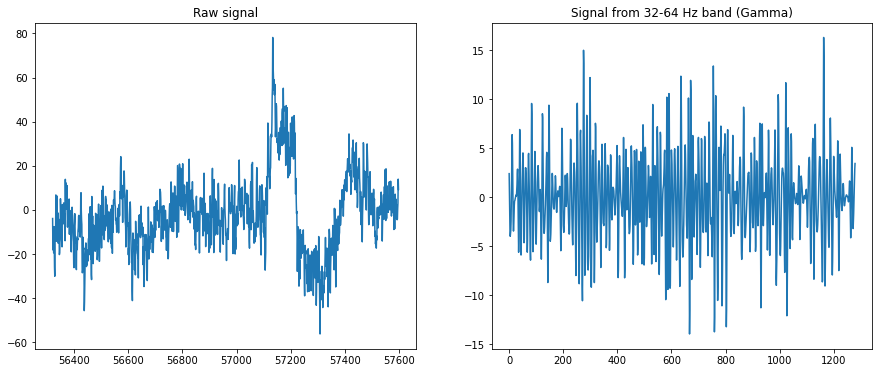

In [4]:
# demonstration of reconstructing cD3 coefficients
wname = 'sym6'
level=5
coeff = pywt.wavedec(df[df['chunk']==42]['eeg_fp1'], 'sym6', mode='per', level=5)
for level in [0,1,2,4,5]:
    coeff[level] = np.zeros_like(coeff[level])

recon_cd3 = pywt.waverec(coeff, 'sym6', mode='per')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(df[df['chunk']==42]['eeg_fp1']), ax1.set_title('Raw signal')
ax2.plot(recon_cd3), ax2.set_title('Signal from 32-64 Hz band (Gamma)')

We'll do this for every signal chunk we have.

### Downcasting dtypes
Our raw dataset is very memory intensive as it holds 4.5 million rows. By almost doubling the number of features we have, we're going to need a lot more memory. I'm going to drop the ECG and GSR features as we're not using them, and I'm also going to downcast all float64 columns into float32 to save memory.

In [45]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].astype('float32')

In [33]:
df.drop(columns=['pilot', 'experiment','crew','seat','ecg','gsr','ecg_denoised','r', 'time','rsp_rate'], inplace=True)

### Reconstruction 

In [41]:
eeg_cols = df.columns[df.columns.str.contains('eeg')]

In [49]:
for channel in eeg_cols:
    for chunk in df['chunk'].unique():
        coeff = pywt.wavedec(df[df['chunk']==chunk][channel], 'sym6', mode='per', level=5)
        for level in [0,1,2,4,5]:
            coeff[level] = np.zeros_like(coeff[level])
        recon_cd3 = pywt.waverec(coeff, 'sym6', mode='per')
        df.loc[df['chunk']==chunk, channel+'_cd3'] = recon_cd3
    
    print('{} channel done'.format(channel))

eeg_fp1 channel done
eeg_f7 channel done
eeg_f8 channel done
eeg_t4 channel done
eeg_t6 channel done
eeg_t5 channel done
eeg_t3 channel done
eeg_fp2 channel done
eeg_o1 channel done
eeg_p3 channel done
eeg_pz channel done
eeg_f3 channel done
eeg_fz channel done
eeg_f4 channel done
eeg_c4 channel done
eeg_p4 channel done
eeg_poz channel done
eeg_c3 channel done
eeg_cz channel done
eeg_o2 channel done


In [45]:
# do it one more time for the new columns created
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].astype('float32')

In [10]:
pickle.dump(df, open('./data/df_with_cd3.pickle', 'wb'))

### For loading back processed df

In [123]:
with open('./data/df_with_cd3.pickle', 'rb') as file:
    df = pickle.load(file)

## XCM with augmented dataset
The preprocessing steps below are the same as the previous notebook. We will be running the XCM with base defaults, as we did the first time.

In [126]:
df.columns

Index(['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3',
       'eeg_fp2', 'eeg_o1', 'eeg_p3', 'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',
       'eeg_c4', 'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2', 'event',
       'chunk', 'r_clean', 'rsp_rate', 'eeg_fp1_cd3', 'eeg_f7_cd3',
       'eeg_f8_cd3', 'eeg_t4_cd3', 'eeg_t6_cd3', 'eeg_t5_cd3', 'eeg_t3_cd3',
       'eeg_fp2_cd3', 'eeg_o1_cd3', 'eeg_p3_cd3', 'eeg_pz_cd3', 'eeg_f3_cd3',
       'eeg_fz_cd3', 'eeg_f4_cd3', 'eeg_c4_cd3', 'eeg_p4_cd3', 'eeg_poz_cd3',
       'eeg_c3_cd3', 'eeg_cz_cd3', 'eeg_o2_cd3'],
      dtype='object')

In [127]:
signal_y = df.groupby('chunk')['event'].max().to_numpy()
signal_x = df.drop(columns=['event', 'chunk', 'rsp_rate']).to_numpy().reshape(signal_y.shape[0], 1280, 41)

In [128]:
signalX_train, signalX_val, signaly_train, signaly_val = train_test_split(signal_x, signal_y, stratify=signal_y, random_state=42)

In [129]:
scalers = {}

for i in range(signalX_train.shape[2]):
    scalers[i] = StandardScaler()
    signalX_train[:,:,i] = scalers[i].fit_transform(signalX_train[:,:,i])
    
for i in range(signalX_val.shape[2]):
    signalX_val[:,:,i] = scalers[i].transform(signalX_val[:,:,i])


In [130]:
X2d_train = signalX_train.reshape(signalX_train.shape[0], 1280, 41, 1)
X1d_train = signalX_train.reshape(signalX_train.shape[0], 1280, 1, 41)

X2d_val = signalX_val.reshape(signalX_val.shape[0], 1280, 41, 1)
X1d_val = signalX_val.reshape(signalX_val.shape[0], 1280, 1, 41)

In [131]:
oh_enc = OneHotEncoder(categories='auto', sparse=False)
signaly_train = oh_enc.fit_transform(signaly_train.reshape(-1,1))
signaly_val = oh_enc.transform(signaly_val.reshape(-1,1))

In [10]:
inputs_2D = keras.Input(shape=(1280,41,1), name = '2d')
inputs_1D = keras.Input(shape=(1280,1,41), name = '1d')

conv_2D_layer = layers.Conv2D(filters=128,
                              kernel_size=(256,1),
                              padding='same',
                              strides=(1,1),
                              activation='relu',
                              )(inputs_2D)
conv_2D_layer = layers.BatchNormalization()(conv_2D_layer)
conv_2D_layer = layers.Conv2D(filters=1,
                              kernel_size=(1,1),
                              padding='same',
                              strides=(1,1),
                              activation='relu',
                              )(conv_2D_layer)

conv_1D_layer = layers.Conv1D(filters=128,
                              kernel_size=(256),
                              padding='same',
                              strides=1,
                              activation='relu')(inputs_1D)
conv_1D_layer = layers.BatchNormalization()(conv_1D_layer)
conv_1D_layer = layers.Conv1D(filters=1,
                              kernel_size=1,
                              padding='same',
                              strides=1,
                              activation='relu')(conv_1D_layer)

combined = layers.Concatenate(axis=2)([conv_2D_layer, conv_1D_layer])

combined = layers.Conv1D(filters=128,
                         kernel_size=256,
                         padding='same',
                         strides=1,
                         activation='relu')(combined)
combined = layers.BatchNormalization()(combined)
combined = layers.GlobalAveragePooling2D()(combined)

combined = layers.Dense(4, activation='softmax')(combined)

xcm_1 = keras.Model(inputs = [inputs_2D, inputs_1D], outputs=[combined])

xcm_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

In [11]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=20, mode='auto')
checkpoint_filepath = './keras_checkpoints/best_xcm_withcd3.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [12]:
xcm_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
2d (InputLayer)                 [(None, 1280, 41, 1) 0                                            
__________________________________________________________________________________________________
1d (InputLayer)                 [(None, 1280, 1, 41) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1280, 41, 128 32896       2d[0][0]                         
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1280, 1, 128) 1343616     1d[0][0]                         
______________________________________________________________________________________________

In [21]:
# had to restart training due to Out of Memory error
history_xcm = xcm_1.fit(
    {'2d': X2d_train,
     '1d': X1d_train},
    signaly_train, 
    validation_data=([X2d_val, X1d_val], signaly_val),
    epochs=1000, 
    initial_epoch=67,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 68/1000
82/82 [==============================] - 164s 2s/step - loss: 0.2345 - acc: 0.9183 - val_loss: 0.5853 - val_acc: 0.8126
Epoch 69/1000
82/82 [==============================] - 164s 2s/step - loss: 0.1990 - acc: 0.9344 - val_loss: 0.6557 - val_acc: 0.8184
Epoch 70/1000
82/82 [==============================] - 165s 2s/step - loss: 0.2157 - acc: 0.9264 - val_loss: 0.3963 - val_acc: 0.8770
Epoch 71/1000
82/82 [==============================] - 167s 2s/step - loss: 0.2121 - acc: 0.9298 - val_loss: 0.3604 - val_acc: 0.8989
Epoch 72/1000
82/82 [==============================] - 164s 2s/step - loss: 0.2179 - acc: 0.9233 - val_loss: 0.4247 - val_acc: 0.8885
Epoch 73/1000
82/82 [==============================] - 165s 2s/step - loss: 0.2174 - acc: 0.9317 - val_loss: 0.4904 - val_acc: 0.8816
Epoch 74/1000
82/82 [==============================] - 164s 2s/step - loss: 0.2003 - acc: 0.9352 - val_loss: 0.4388 - val_acc: 0.8828
Epoch 75/1000
82/82 [==============================] - 163s 2s

In [22]:
probas = xcm_1.predict([X2d_val, X1d_val])
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')

OvR AUROC for A vs rest: 0.9495453537369705
OvR AUROC for B vs rest: 0.7091237579042458
OvR AUROC for C vs rest: 0.9815227272727273
OvR AUROC for D vs rest: 0.898644578313253


0.884709104306799

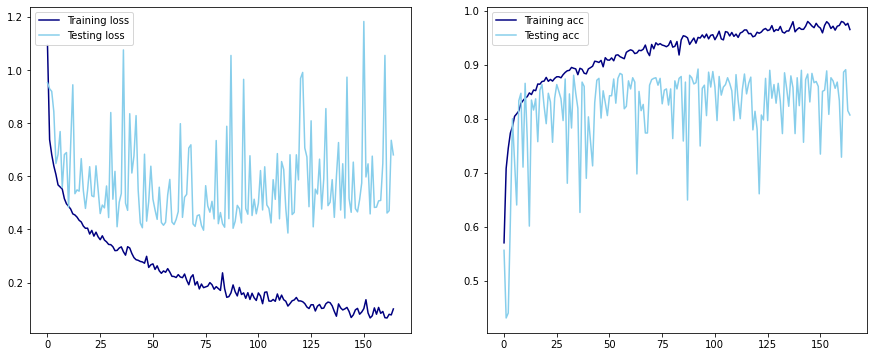

In [38]:
# history object from first run of model
plot_training_history(history_xcm)

The XCM model is still not showing good results, and in fact hasn't done better than our first try with it using the defaults set in the paper. More concerningly, the testing loss fluctuates very violently, indicating that our model is not properly converging. As such, we shouldn't be confident in the results this model returns us.

## MLSTM-FCN model 
Finally, we come to yet another model for multivariate time series data classification. In the XCM paper, the authors compared their XCM model to various other models that been proposed. We've already seen the MTEX, now we will see the Multivariate-LSTM Fully Convolutional Network model. This model was proposed in 2018 by F. Karim et Al., and according to the authors of the XCM, is actually the next best model after their own XCM. Like the XCM, it has 2 layers of inputs that get concatenated towards the end. 

There are 2 unique things about this model as compared to the MTEX and XCM. Firstly, it makes use of an LSTM layer, which we normally see in RNNs. This allows the model to learn some long-term dependencies, which our previous models did not allow for. According to the authors, the features extracted by the LSTM block by themselves do not contribute much to the classifier, but when used in combination with the main CNN block, results in a more robust set of features that lead to increased model performance. 

Secondly, this model makes use of something called the *squeeze-excite* block, first prposed by Hu et al. (2018). At a high level of understanding, the *squeeze-excite* block seeks to make certain learned features more important than others. In a typical convolutional layer, each filter acts as a feature extractor. The motivation for the *squeeze-excite* block is that not every learned feature map is equally important, and so through a sequence of squeezing through a pooling layer and excitation back through densely connected layers ending with sigmoid activation, new channel weights get learned that prioritize certain channels over others. [This article](https://blog.paperspace.com/channel-attention-squeeze-and-excitation-networks/) is useful reading regarding the squeeze-excite block.

<img src='./images/mlstm_architecture.png' style='width: 800'>

Source: https://github.com/houshd/MLSTM-FCN/blob/master/eeg_model.py

    @misc{Karim2018,
      Author = {Fazle Karim and Somshubra Majumdar and Houshang Darabi and Samuel Harford},
      Title = {Multivariate LSTM-FCNs for Time Series Classification},
      Year = {2018},
      Eprint = {arXiv:1801.04503},
    }

The MLSTM-FCN model requires our input to be shaped as such
    
    (n_samples, n_features, n_timesteps)
Essentially we just need to transpose each individual observation from (1280,41) to (41,1280). Since we still have the original signalX_train and signalX_val, we can very easily do this. 

In [132]:
Xtrain_mlstm = np.zeros((signalX_train.shape[0], signalX_train.shape[2], signalX_train.shape[1]))
for i in range(signalX_train.shape[0]):
    Xtrain_mlstm[i] = signalX_train[i].T

Xval_mlstm = np.zeros((signalX_val.shape[0], signalX_val.shape[2], signalX_val.shape[1]))
for i in range(signalX_val.shape[0]):
    Xval_mlstm[i] = signalX_val[i].T

This code below supports the creation of the squeeze-excite block, which is one of the key components in the MLSTM-FCN.

In [121]:
def squeeze_excite_block(input):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    filters = input.shape[-1] # channel_axis = -1 for TF
    
    # this global pooling layer performs the 'squeeze' part of the block
    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    # this step performs the 'excite' part of the block
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    # this steps applies the channel weight to the input channels
    se = multiply([input, se])
    # we now have a tensor with weighted channels
    return se

### MLSTM first run
For the first run, we'll leave the defaults as is, with the exception of batch_size which I change to 32 for memory purposes.

In [78]:
ip = Input(shape=(41, 1280))

# this masking layer catches all time steps that have a value of 0 and skips them, if there are any
lstm_block = Masking()(ip)
# lstm block captures the entire history of each variable
lstm_block = LSTM(8)(lstm_block)
lstm_block = Dropout(0.8)(lstm_block)

# this step performs a 'dimension shuffle' which improves efficiency.
# for an input of length T timesteps, this step now treats it as a multivariate input with T features and timestep of 1.
conv1d_block = Permute((2, 1))(ip)

# each set of conv1d block acts as a feature extraction layer.
# this model has 3 such extraction layers
conv1d_block = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(conv1d_block)
conv1d_block = BatchNormalization()(conv1d_block)
conv1d_block = Activation('relu')(conv1d_block)
conv1d_block = squeeze_excite_block(conv1d_block)
# this is the end of one full conv1d block

# feature extraction repeats
conv1d_block = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(conv1d_block)
conv1d_block = BatchNormalization()(conv1d_block)
conv1d_block = Activation('relu')(conv1d_block)
conv1d_block = squeeze_excite_block(conv1d_block)

# feature extraction repeats
conv1d_block = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(conv1d_block)
conv1d_block = BatchNormalization()(conv1d_block)
conv1d_block = Activation('relu')(conv1d_block)


conv1d_block = GlobalAveragePooling1D()(conv1d_block)

# combine both blocks 
combined = concatenate([lstm_block, conv1d_block])

# output to a dense layer with softmax activation
out = Dense(4, activation='softmax')(combined)

mlstm_1 = keras.Model(ip, out)

mlstm_1.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[keras.metrics.AUC()])

In [79]:
mlstm_1.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 41, 1280)]   0                                            
__________________________________________________________________________________________________
permute_8 (Permute)             (None, 1280, 41)     0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 1280, 128)    42112       permute_8[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 1280, 128)    512         conv1d_26[0][0]                  
____________________________________________________________________________________________

In [80]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=20, mode='auto')
checkpoint_filepath = './keras_checkpoints/mlstm_4.1.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [82]:
history_mlstm1 = mlstm_1.fit(
    Xtrain_mlstm,
    signaly_train, 
    validation_data=(Xval_mlstm, signaly_val),
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
82/82 [==============================] - 15s 124ms/step - loss: 0.9434 - auc_1: 0.8424 - val_loss: 1.2411 - val_auc_1: 0.7351
Epoch 2/1000
82/82 [==============================] - 8s 102ms/step - loss: 0.5811 - auc_1: 0.9393 - val_loss: 0.7053 - val_auc_1: 0.9468
Epoch 3/1000
82/82 [==============================] - 8s 101ms/step - loss: 0.5003 - auc_1: 0.9551 - val_loss: 0.5060 - val_auc_1: 0.9595
Epoch 4/1000
82/82 [==============================] - 8s 101ms/step - loss: 0.4257 - auc_1: 0.9669 - val_loss: 0.3651 - val_auc_1: 0.9769
Epoch 5/1000
82/82 [==============================] - 8s 102ms/step - loss: 0.3790 - auc_1: 0.9738 - val_loss: 0.4681 - val_auc_1: 0.9602
Epoch 6/1000
82/82 [==============================] - 8s 102ms/step - loss: 0.3797 - auc_1: 0.9739 - val_loss: 0.5646 - val_auc_1: 0.9536
Epoch 7/1000
82/82 [==============================] - 8s 101ms/step - loss: 0.3251 - auc_1: 0.9804 - val_loss: 0.4476 - val_auc_1: 0.9654
Epoch 8/1000
82/82 [=============

In [143]:
# save history object
pickle.dump(history_mlstm1.history, open('./data/history_mlstm1.pickle', 'wb'))

In [48]:
# load back best model iteration
best_mlstm_1 = keras.models.load_model('./keras_checkpoints/mlstm_4.1.h5')

In [135]:
probas = best_mlstm_1.predict(Xval_mlstm)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.966646652494469
OvR AUROC for B vs rest: 0.860369079881275
OvR AUROC for C vs rest: 0.9863693181818182
OvR AUROC for D vs rest: 0.9507228915662651
Macro AUROC: 0.9410269855309568


Right out the gate, the best iteration of this model already gives us FAR superior results to any CNN we've tried so far. It also produces stronger results than our current LGBM model. Most notably our AUROC for class B is now 0.86, a full 0.05 more than what our LGBM model produced. 

Another key advantage of this model is that it trains extremely fast. Previously our XCM model took 2.5-3mins per epoch to train. In comparison, the MLSTM-FCN takes 8s per epoch. From a standpoint of performance, speed, and model complexity, this model is miles ahead of the XCM for our purposes.

In [ ]:
# save this model into our data folder
best_mlstm_1.save('./data/mlstm_best_adam.h5')

#### Visualizing results
Let's take a look at our ROC scores as well as the loss scores from our history object.

In [51]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

def precision(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    try:
        return true_positive/ (true_positive + false_positive)
    except:
        return 1

In [93]:
results['y_isB'] = (results['y_true'].map(lambda x: 1 if x=='B' else 0)).astype(int)
results['y_isD'] = (results['y_true'].map(lambda x: 1 if x=='D' else 0)).astype(int)

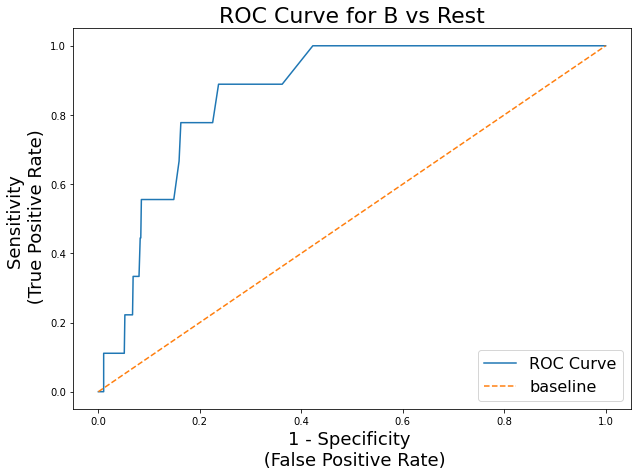

In [94]:
ovr_roc_curve(results, 'y_isB', 'B')

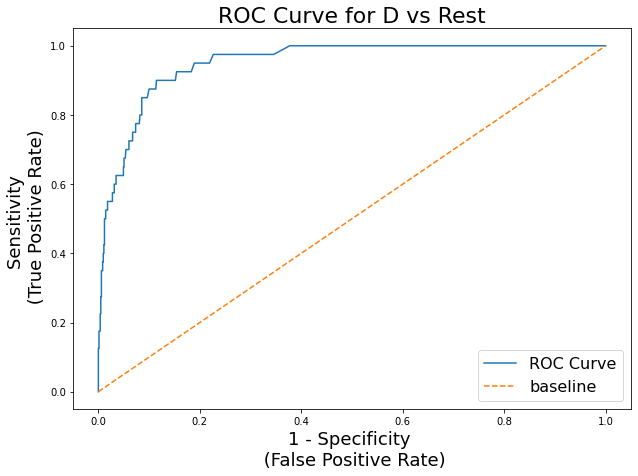

In [95]:
ovr_roc_curve(results, 'y_isD', 'D')

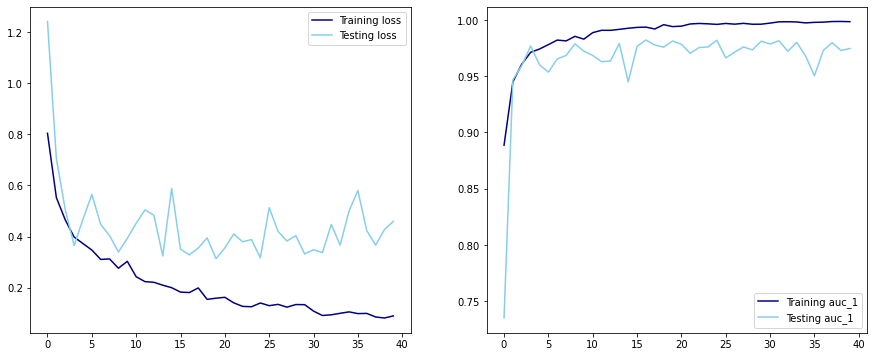

In [98]:
plot_training_history(history_mlstm1, 'loss', 'auc_1')

Both ROC curves for our minority classes look really good. For both classes, perfect recall is achieved when FPR is around 0.4. This is marked improvement from our LGBM model, and shows that the MLSTM-FCN is properly learning the patterns in our data. Furthermore, while the graph of training vs testing loss still shows that testing loss is rather variable, it is still much more stable than in both the MTEX and XCM models, where testing loss fluctuated much more violently. Once our testing loss 'converges' it fluctuates between 0.4 and 0.6. For this run, we monitored AUC instead of accuracy, but Keras's AUC score is likely computed using weighted ROC instead of macro ROC, so we will go back to using accuracy instead.

As our training and testing loss and AUROC do not converge at the same level, it shows us that there is room for improvement still. We should also try to get our validation loss to converge more stably, as that will give us more confidence that our model has reached a global minima.

### MLSTM using only raw signals

This run is simply to observe how the model performs when it is only fed the raw signals without the reconstructed cD3 signals.

In [31]:
signal_x = df.drop(columns=df.columns[df.columns.str.contains('cd3')]).drop(columns=['event','chunk','rsp_rate'])

In [35]:
signal_x = signal_x.to_numpy().reshape(signal_y.shape[0], 1280, 21)

In [36]:
signalX_train, signalX_val, signaly_train, signaly_val = train_test_split(signal_x, signal_y, stratify=signal_y, random_state=42)

In [38]:
scalers = {}

for i in range(signalX_train.shape[2]):
    scalers[i] = StandardScaler()
    signalX_train[:,:,i] = scalers[i].fit_transform(signalX_train[:,:,i])
    
for i in range(signalX_val.shape[2]):
    signalX_val[:,:,i] = scalers[i].transform(signalX_val[:,:,i])


In [39]:
Xtrain_mlstm = np.zeros((signalX_train.shape[0], signalX_train.shape[2], signalX_train.shape[1]))
for i in range(signalX_train.shape[0]):
    Xtrain_mlstm[i] = signalX_train[i].T

Xval_mlstm = np.zeros((signalX_val.shape[0], signalX_val.shape[2], signalX_val.shape[1]))
for i in range(signalX_val.shape[0]):
    Xval_mlstm[i] = signalX_val[i].T

In [40]:
Xtrain_mlstm.shape

(2608, 21, 1280)

In [41]:
ip = Input(shape=(21, 1280))

x = Masking()(ip)
x = LSTM(8)(x)
x = Dropout(0.8)(x)

y = Permute((2, 1))(ip)
y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = squeeze_excite_block(y)

y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = squeeze_excite_block(y)

y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)

y = GlobalAveragePooling1D()(y)

x = concatenate([x, y])

out = Dense(4, activation='softmax')(x)

mlstm_2 = keras.Model(ip, out)

mlstm_2.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[keras.metrics.AUC()])

In [42]:
mlstm_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 21, 1280)]   0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 1280, 21)     0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1280, 128)    21632       permute_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 1280, 128)    512         conv1d_3[0][0]                   
____________________________________________________________________________________________

In [43]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=20, mode='auto')
checkpoint_filepath = './keras_checkpoints/mlstm_4.2.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)

In [44]:
history_mlstm2 = mlstm_2.fit(
    Xtrain_mlstm,
    signaly_train, 
    validation_data=(Xval_mlstm, signaly_val),
    epochs=1000, 
    batch_size=32,
    callbacks=[early_stop, model_checkpoint]
    )

Epoch 1/1000
82/82 [==============================] - 15s 117ms/step - loss: 0.9036 - auc_1: 0.8541 - val_loss: 0.8905 - val_auc_1: 0.9017
Epoch 2/1000
82/82 [==============================] - 8s 97ms/step - loss: 0.5819 - auc_1: 0.9396 - val_loss: 0.6574 - val_auc_1: 0.9462
Epoch 3/1000
82/82 [==============================] - 8s 98ms/step - loss: 0.5029 - auc_1: 0.9541 - val_loss: 0.5884 - val_auc_1: 0.9416
Epoch 4/1000
82/82 [==============================] - 8s 98ms/step - loss: 0.4306 - auc_1: 0.9656 - val_loss: 0.5759 - val_auc_1: 0.9432
Epoch 5/1000
82/82 [==============================] - 8s 98ms/step - loss: 0.4213 - auc_1: 0.9677 - val_loss: 0.4329 - val_auc_1: 0.9666
Epoch 6/1000
82/82 [==============================] - 8s 98ms/step - loss: 0.3639 - auc_1: 0.9758 - val_loss: 0.5202 - val_auc_1: 0.9558
Epoch 7/1000
82/82 [==============================] - 8s 98ms/step - loss: 0.3821 - auc_1: 0.9737 - val_loss: 0.3974 - val_auc_1: 0.9715
Epoch 8/1000
82/82 [===================

In [45]:
# load back best model iteration
best_mlstm_2 = keras.models.load_model('./keras_checkpoints/mlstm_4.2.h5')

In [46]:
probas = best_mlstm_2.predict(Xval_mlstm)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.9474384564204923
OvR AUROC for B vs rest: 0.8062975867853917
OvR AUROC for C vs rest: 0.9740795454545454
OvR AUROC for D vs rest: 0.9324397590361445
Macro AUROC: 0.9150638369241435


As expected, without the help of the cD3 reconstructed signals, our model doesn't do as well, although it is still on par with the LGBM. This shows that reconstructing the cD3 signals allowed our model to learn patterns in the data better.

### MLSTM finetuning

In this section I'm going to train many models to primarily see if I can smoothen the val loss, but also to see if I can improve our model performance. I will note my findings at the end.

In [ ]:
signal_y = df.groupby('chunk')['event'].max().to_numpy()
signal_x = df.drop(columns=['event', 'chunk', 'rsp_rate']).to_numpy().reshape(signal_y.shape[0], 1280, 41)

In [ ]:
signalX_train, signalX_val, signaly_train, signaly_val = train_test_split(signal_x, signal_y, stratify=signal_y, random_state=42)

In [ ]:
scalers = {}

for i in range(signalX_train.shape[2]):
    scalers[i] = StandardScaler()
    signalX_train[:,:,i] = scalers[i].fit_transform(signalX_train[:,:,i])
    
for i in range(signalX_val.shape[2]):
    signalX_val[:,:,i] = scalers[i].transform(signalX_val[:,:,i])


In [ ]:
Xtrain_mlstm = np.zeros((signalX_train.shape[0], signalX_train.shape[2], signalX_train.shape[1]))
for i in range(signalX_train.shape[0]):
    Xtrain_mlstm[i] = signalX_train[i].T

Xval_mlstm = np.zeros((signalX_val.shape[0], signalX_val.shape[2], signalX_val.shape[1]))
for i in range(signalX_val.shape[0]):
    Xval_mlstm[i] = signalX_val[i].T

In [ ]:
oh_enc = OneHotEncoder(categories='auto', sparse=False)
signaly_train = oh_enc.fit_transform(signaly_train.reshape(-1,1))
signaly_val = oh_enc.transform(signaly_val.reshape(-1,1))

In [36]:
# setting these random seeds actually does not result in reproducibility as we are using GPU to train
# but at least we can still control for some of the randomness.
np.random.seed(42)
tf.random.set_seed(42)

ip = Input(shape=(41, 1280))

# this masking layer catches all time steps that have a value of 0 and skips them, if there are any
lstm_block = Masking()(ip)
# lstm block captures the entire history of each variable
lstm_block = LSTM(8)(lstm_block)
lstm_block = Dropout(0.8)(lstm_block)

# this step performs a 'dimension shuffle' which improves efficiency.
# for an input of length T timesteps, this step now treats it as a multivariate input with T features and timestep of 1.
conv1d_block = Permute((2, 1))(ip)

# each set of conv1d block acts as a feature extraction layer.
# this model has 3 such extraction layers
conv1d_block = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(conv1d_block)
conv1d_block = BatchNormalization()(conv1d_block)
conv1d_block = Activation('relu')(conv1d_block)
conv1d_block = squeeze_excite_block(conv1d_block)
# this is the end of one full conv1d block

# feature extraction repeats
conv1d_block = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(conv1d_block)
conv1d_block = BatchNormalization()(conv1d_block)
conv1d_block = Activation('relu')(conv1d_block)
conv1d_block = squeeze_excite_block(conv1d_block)

# feature extraction repeats
conv1d_block = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(conv1d_block)
conv1d_block = BatchNormalization()(conv1d_block)
conv1d_block = Activation('relu')(conv1d_block)


conv1d_block = GlobalAveragePooling1D()(conv1d_block)

# combine both blocks 
combined = concatenate([lstm_block, conv1d_block])

# output to a dense layer with softmax activation
out = Dense(4, activation='softmax')(combined)

mlstm_3 = keras.Model(ip, out)

opt = keras.optimizers.Adam(learning_rate=0.0001)
mlstm_3.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])

In [37]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=50, mode='auto')
checkpoint_filepath = './keras_checkpoints/mlstm_4.3.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                         monitor='val_loss',
                                         mode='auto',
                                         save_best_only=True)
csv_logger = CSVLogger('./keras_checkpoints/mlstm_4.3.log', separator=',', append=False)

def schedule(epoch, lr):
    if epoch<50:
        return lr
    else: 
        return 0.00001
    
lr_scheduler = LearningRateScheduler(schedule)

In [14]:
mlstm_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 41, 1280)]   0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 1280, 41)     0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1280, 128)    42112       permute_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1280, 128)    512         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
weights = class_weighter.compute_class_weight('balanced', classes = np.array(['A','B','C','D']), y=signaly_train)
weights = {k:v for (k,v) in enumerate(weights)}
weights

{0: 0.4337990685296075, 1: 26.08, 2: 0.6798748696558915, 3: 5.3884297520661155}

In [38]:
history_mlstm3 = mlstm_3.fit(
    Xtrain_mlstm,
    signaly_train, 
    validation_data=(Xval_mlstm, signaly_val),
    epochs=1000, 
    batch_size=32,
    class_weight=weights,
#     initial_epoch=795,
    callbacks=[early_stop, model_checkpoint, csv_logger, lr_scheduler]
    )

Epoch 1/1000
82/82 [==============================] - 16s 122ms/step - loss: 1.3620 - acc: 0.4122 - val_loss: 1.4045 - val_acc: 0.2862
Epoch 2/1000
82/82 [==============================] - 8s 100ms/step - loss: 1.3323 - acc: 0.4138 - val_loss: 1.2489 - val_acc: 0.4310
Epoch 3/1000
82/82 [==============================] - 8s 102ms/step - loss: 1.2891 - acc: 0.4236 - val_loss: 1.1834 - val_acc: 0.5057
Epoch 4/1000
82/82 [==============================] - 8s 99ms/step - loss: 1.1604 - acc: 0.4469 - val_loss: 1.0993 - val_acc: 0.5322
Epoch 5/1000
82/82 [==============================] - 8s 99ms/step - loss: 1.1223 - acc: 0.4521 - val_loss: 1.1376 - val_acc: 0.5678
Epoch 6/1000
82/82 [==============================] - 8s 99ms/step - loss: 1.1008 - acc: 0.4760 - val_loss: 1.1305 - val_acc: 0.5713
Epoch 7/1000
82/82 [==============================] - 8s 99ms/step - loss: 1.0575 - acc: 0.4986 - val_loss: 1.0661 - val_acc: 0.6000
Epoch 8/1000
82/82 [==============================] - 8s 99ms/ste

Epoch 62/1000
82/82 [==============================] - 8s 100ms/step - loss: 0.1896 - acc: 0.9024 - val_loss: 0.4612 - val_acc: 0.8218
Epoch 63/1000
82/82 [==============================] - 8s 100ms/step - loss: 0.1793 - acc: 0.9096 - val_loss: 0.4324 - val_acc: 0.8333
Epoch 64/1000
82/82 [==============================] - 8s 100ms/step - loss: 0.1997 - acc: 0.9082 - val_loss: 0.4710 - val_acc: 0.8230
Epoch 65/1000
82/82 [==============================] - 8s 101ms/step - loss: 0.1992 - acc: 0.9051 - val_loss: 0.4363 - val_acc: 0.8391
Epoch 66/1000
82/82 [==============================] - 8s 101ms/step - loss: 0.1843 - acc: 0.9029 - val_loss: 0.4232 - val_acc: 0.8379
Epoch 67/1000
82/82 [==============================] - 8s 101ms/step - loss: 0.1752 - acc: 0.9092 - val_loss: 0.4901 - val_acc: 0.8080
Epoch 68/1000
82/82 [==============================] - 8s 100ms/step - loss: 0.1864 - acc: 0.8868 - val_loss: 0.4489 - val_acc: 0.8230
Epoch 69/1000
82/82 [==============================] - 

In [41]:
# load back best model iteration
best_mlstm_3 = keras.models.load_model('./keras_checkpoints/mlstm_4.3.h5')

In [42]:
probas = best_mlstm_3.predict(Xval_mlstm)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.9493587351043172
OvR AUROC for B vs rest: 0.755065169699316
OvR AUROC for C vs rest: 0.976625
OvR AUROC for D vs rest: 0.9488253012048193
Macro AUROC: 0.907468551502113


In [189]:
# best_mlstm_3.save('./data/mlstm_best_adam_lradjusted.h5')

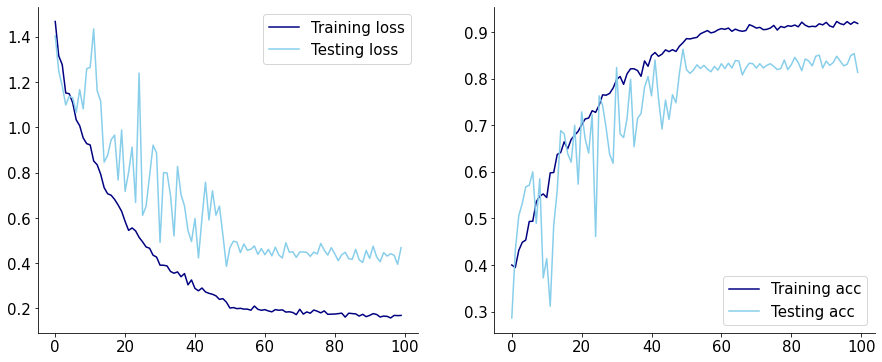

In [28]:
mlstm3_logs = pd.read_csv('./keras_checkpoints/mlstm_4.3.log')
plot_training_history(mlstm3_logs, 'loss', 'acc', from_csv=True);

In [340]:
# best_mlstm_3.save('./data/mlstm_best_rmsprop.h5')

#### Visualizing results
Our best model was trained using Adam with LearningRateScheduler with learning rate of 0.0001 for the first 50 epochs, then 0.00001 after that, and balanced class weights calculated using sklearn.

In [134]:
# load best model 
model = keras.models.load_model('./data/mlstm_best_adam_lradjusted.h5')
probas = model.predict(Xval_mlstm)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.9632009693350426
OvR AUROC for B vs rest: 0.8713382371918956
OvR AUROC for C vs rest: 0.9854261363636363
OvR AUROC for D vs rest: 0.9640963855421687
Macro AUROC: 0.9460154321081857


In [135]:
results['y_isB'] = (results['y_true'].map(lambda x: 1 if x=='B' else 0)).astype(int)
results['y_isD'] = (results['y_true'].map(lambda x: 1 if x=='D' else 0)).astype(int)

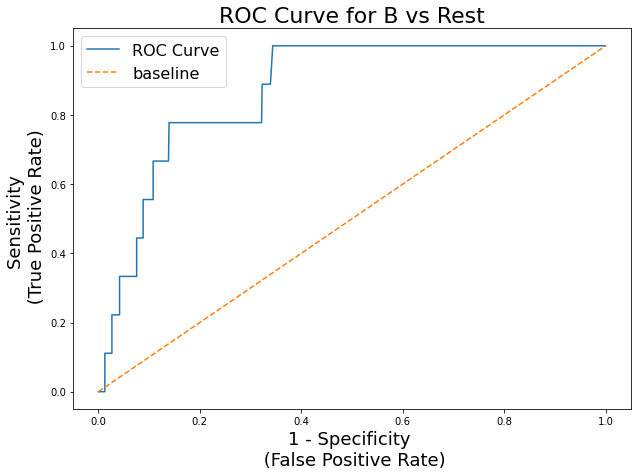

In [92]:
ovr_roc_curve(results, 'y_isB', 'B', 50000);

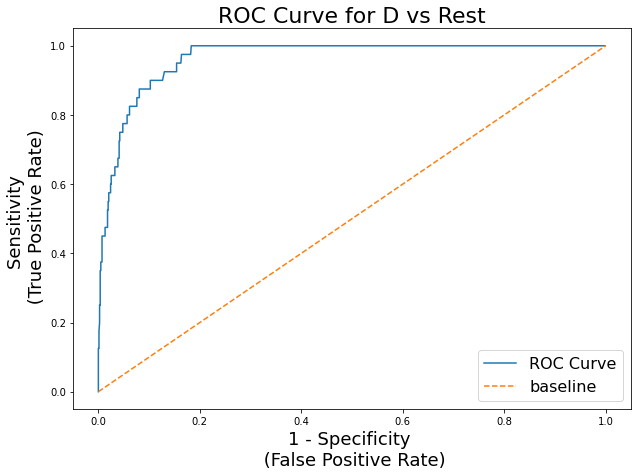

In [62]:
ovr_roc_curve(results, 'y_isD', 'D');

In [152]:
# to load history logs
mlstm_logs = pd.read_csv('./keras_checkpoints/mlstm_best_adam_lradjusted_B87.log')

In [164]:
mlstm_logs.loc[127]

epoch       127.000000
acc           0.985046
loss          0.036255
val_acc       0.895402
val_loss      0.322694
Name: 127, dtype: float64

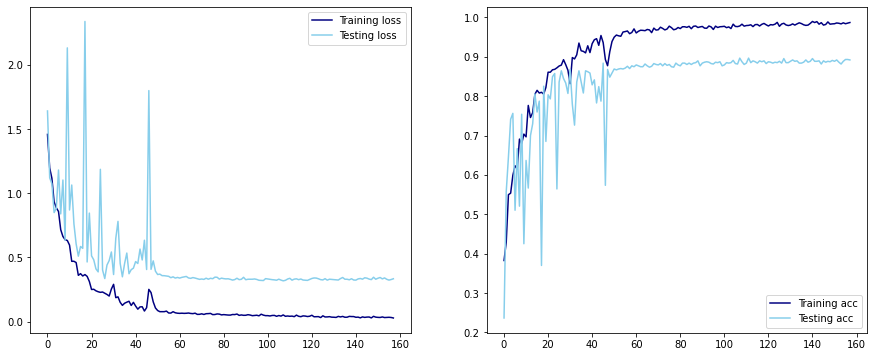

In [59]:
plot_training_history(mlstm_logs, 'loss', 'acc', from_csv=True)

### Tuning observations
These are my observations after changing different hyperparameters.
 
1. Optimizers
    - SGD tended to converge at a lower log loss than the rest, BUT it always consistently produced worse results for class B AUROC, and macro AUROC never went above 0.9. I suspect that because we optimise for categorical cross-entropy and we have so few observations for class B, the poor performance of class B has very little impact on log loss, thus our model just optimises for the other classes
    - ADAM provides the most 'consistent' performance in between runs. Val loss becomes more stable after lowering LR to 1e-05 or more.
    - RMSprop optimized models gave us the most models with over 0.90 macro AUROC, but the log loss fluctuates more than using ADAM. 
    - For both ADAM and RMSprop, using a LR of 1e-05 or lower helps to make val loss fluctuate much less.
    
    
2. Class weights
    - Class weights is essential is ensuring that model performance in between runs is more consistent. Using balanced class weights produces models that consistently have above 0.9 macro AUROC, with at least 0.8 AUROC for class B.
    - In other runs without using class weights, class B AUROC can vary between 0.67 to 0.8x.
    - Setting balanced class weights without setting a low LR rate will still result in very volatile val loss.


3. Batch size
    - larger batch sizes cause very erratic val loss fluctuations. 64 and 128 produced bad results. 32 seems optimal.


4. Adjusting complexity of model
    - I tried reducing the number of filters in the convolutional layers, but these models did worse. 
    - I experimented with using 8, 16, 32, and 64 LSTM units. 8 units gave us consistently better results.
    - Dropout rate was also adjusted, but there was no consistent effect observed when changing this parameter.
    

5. Using GPU does not allow for reproducibility.
    - Even though we set both NumPy and TensorFlow random seeds, because we are using Nvidia's CuDNN GPU backend to run our models, we can't control for the randomness from the GPU. There will always be some variation in the model training results, although I notice that at least setting the NumPy and TF seeds makes it 'less' random.
    - Depending on what machine this notebook is run on and what GPU it has, it is likely that the hyperparameters we chose for our models here will no longer produce the best performing model. 

## Model Evaluation

This is a summary of my experience implementing the 3 different CNN architectures.

1. MTEX-CNN
    - Pros:
        - Sequential structure is easy to understand
        - Trains relatively fast
        - Flexible architecture that allows for more Conv2D or Conv1D layers as needed.
        - Can be extended to include the explainable grad-CAM layer, although that was designed more for images.
    - Cons:
        - Model won't converge
2. XCM
    - Pros:
        - Can at least beat our baseline model
        - Like the MTEX, can be made to be explainable via a grad-CAM layer
    - Cons:
        - Still slightly worse than our tuned LGBM model
        - Architecture is complex and difficult to implement
            - poor performance and erratic val loss likely due to improper implementation
        - Training takes inordinately long, making this unviable in production
3. MLSTM-FCN
    - Pros:
        - Fairly simple to implement even though it still requires 2 concurrent layers
        - Training is very fast; less params than the previous models.
        - Loss function converges much more stably than XCM
        - Produces superior discriminability as compared to our tuned LGBM model
    - Cons:
        - Unlike the MTEX or XCM, which *can* be made to be explainable through the use of grad-CAM layers, the MLSTM-FCN does not provide explainability.
        
Our initial problem statement was to build a classifier that would warn pilots when they were entering an undesirable mental state. This is in the interest of operational and passenger safety. The value of such a classifier lies in its operational usefulness more so than its potential for medical research. As such, explainability is not as high as priority as model predictiveness, meaning that the MLSTM-FCN is actually a suitable model for our needs. It is lightweight as compared to the XCM, trains fast, and does not require much data preprocessing. In terms of a model that can be deployed into real-life use, the MLSTCM-FCN would work well. 

Of course, a good future improvement would be to build an explainable model that helps us understand how to best detect these undesirable states, but these could be done more in a lab setting, where deployability and complexity are not as big an issue. We could continue gathering more data and use a more complex model like the XCM, properly implemented this time with a grad-CAM layer as well, to then study the best predictors for undesirable mental states.

For now let's take a look at our predicted probabilities. We know that metrics such as recall and specificity can be adjusted by applying a moving threshold. Let's take a what happens if we were to set recall to 1.

In [63]:
probas = model.predict(Xval_mlstm)
results = pd.DataFrame(probas, columns=['A','B','C','D'])
results['y_true'] = oh_enc.inverse_transform(signaly_val).flatten()
individual_ovr_roc_score(results)
# display(roc_auc_score(signaly_train, model.predict(signalX_train), multi_class='ovr', average='macro'))
print('Macro AUROC: {}'.format(roc_auc_score(signaly_val, probas, multi_class='ovr', average='macro')))

OvR AUROC for A vs rest: 0.9632009693350426
OvR AUROC for B vs rest: 0.8713382371918956
OvR AUROC for C vs rest: 0.9854261363636363
OvR AUROC for D vs rest: 0.9640963855421687
Macro AUROC: 0.9460154321081857


In [66]:
results['y_isB'] = (results['y_true'].map(lambda x: 1 if x=='B' else 0)).astype(int)
results['y_isD'] = (results['y_true'].map(lambda x: 1 if x=='D' else 0)).astype(int)

In [64]:
## looking at class B
results[results['y_true']=='B'].sort_values(by='B')

,A,B,C,D,y_true
292,0.996649,0.000411,2.930583e-03,0.000010,B
677,0.998638,0.000490,7.885000e-04,0.000083,B
609,0.011821,0.005610,2.201374e-07,0.982569,B
324,0.988172,0.011776,1.257223e-06,0.000051,B
782,0.982818,0.016817,2.900176e-04,0.000075,B
357,0.782078,0.021575,1.702133e-02,0.179326,B
689,0.391809,0.082414,4.598000e-01,0.065977,B
150,0.851302,0.145133,3.446042e-03,0.000119,B
263,0.425477,0.384873,1.877881e-01,0.001862,B


For perfect recall for class B, we would need to set our B threshold to 0.000411, which is really low. Let's see our False Positive rate at this threshold.

In [73]:
print('False Positive Rate: {}'.format(FPR(results, 'y_isB','B',0.000411)))

False Positive Rate: 0.34262485481997673


What if we allow for some false negatives, and set our threshold at 0.005609 instead? At this threshold, we will get 2 false negatives.

In [74]:
print('False Positive Rate: {}'.format(FPR(results, 'y_isB','B',0.005609)))

False Positive Rate: 0.13937282229965153


In [75]:
print('True Positive Rate (Recall): {}'.format(TPR(results, 'y_isB','B',0.005609)))

True Positive Rate (Recall): 0.7777777777777778


Our recall drops a lot compared to our FPR due to us having very few observations for class B. Every correct class B prediction increases recall by 0.11.

We do note that in general the predicted probabilities for this class are all quite low. This is a problem that we also saw with our LGBM model. It seems that our model considers this class to be very unlikely. We will discuss the usefulness of this particular class later in our conclusions section.

In [76]:
# looking at class D
results[results['y_true']=='D'].sort_values(by='D')

,A,B,C,D,y_true,y_isB,y_isD
790,0.991439,1.286363e-03,1.436059e-03,0.005838,D,0,1
257,0.968958,1.365476e-04,2.097907e-02,0.009927,D,0,1
369,0.984729,2.811671e-03,3.293652e-04,0.012130,D,0,1
735,0.914364,1.139659e-02,5.705831e-02,0.017181,D,0,1
414,0.963653,4.132041e-04,1.211974e-03,0.034722,D,0,1
120,0.933748,5.096433e-04,4.692421e-03,0.061050,D,0,1
323,0.043500,5.593428e-05,8.859180e-01,0.070526,D,0,1
434,0.882000,9.142362e-03,2.148853e-04,0.108643,D,0,1
852,0.821140,6.304358e-04,2.435901e-02,0.153871,D,0,1
165,0.763861,8.548328e-04,2.655952e-07,0.235284,D,0,1


For perfect recall for class D, we would need to set our threshold at 0.005838. Let's look at our FPR in that scenario.

In [78]:
print('False Positive Rate: {}'.format(FPR(results, 'y_isD','D', 0.005838)))

False Positive Rate: 0.18313253012048192


What if we set our threshold to be 0.07 instead? Let's calculate our TPR and FPR for that.

In [80]:
print('False Positive Rate: {}'.format(FPR(results, 'y_isD','D', 0.07)))

False Positive Rate: 0.07831325301204817


In [79]:
print('True Positive Rate (Recall): {}'.format(TPR(results, 'y_isD','D',0.07)))

True Positive Rate (Recall): 0.85


In this case, we get pretty good results. For 0.85 recall, we have an FPR of 0.08. This class does much better than class B, which is good to hear, because in my opinion, it is more useful to predict Distracted Attention than it is to predict Startled/Surprised.
***
When we are dealing with moving thresholds in a multi-class situation, we have to make certain decisions when a particular observation meets that threshold for 2 or more classes. For instance, let's say my threshold for classifying something as class B is 0.1, and my threshold for classifying something as class D is 0.2. If I have an observation for which the predicted probability is 0.15 for class B and 0.25 for class D. It meets the threshold to be classified as both classes. In such a case, the user of the classifier has to make an executive decision as to which class should take precedence. In our case, I feel that class D is more important than class B, i.e. there is greater cost in misclassifying class D than there is in misclassifying class B. As such, for me, such an observation would be classified as class D.

Below we'll illustrate a confusion matrix where we apply thresholds of 0.01 for class B and 0.07 for class D, prioritizing class D predictions over class B.

In [168]:
preds=[]
for row in probas:
    # apply threshold for class D first
    if row[3]>=0.07:
        preds.append(3)
    # then apply threshold for class B
    elif row[1]>=0.01:
        preds.append(1)
    # otherwise assign the observation to the class with the highest predicted probability
    else:
        preds.append(np.argmax(row))

In [169]:
results['thresholded_preds'] = preds
results['thresholded_preds'] = results['thresholded_preds'].replace({0:'A', 1:'B', 2:'C', 3:'D'})

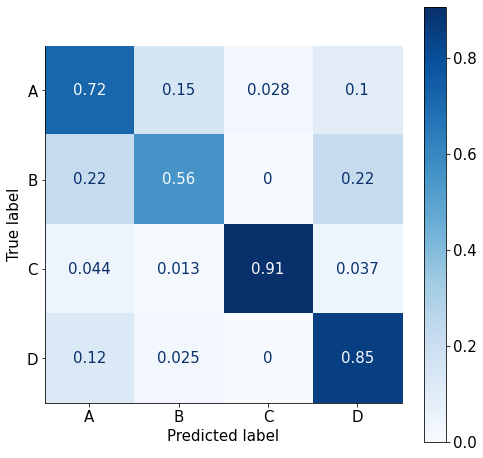

In [170]:
fig, ax = plt.subplots(figsize=(8,8))
cm = confusion_matrix(results['y_true'], results['thresholded_preds'], labels= ['A','B','C','D'], normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels= ['A','B','C','D'])
disp.plot(cmap=plt.cm.Blues, ax=ax)

For this set of predictions we can also calculate an F1-score for it.

In [156]:
print('F1 micro score: {:.3f}'.format(f1_score(results['y_true'], results['thresholded_preds'], average='micro')))
print('F1 macro score: {:.3f}'.format(f1_score(results['y_true'], results['thresholded_preds'], average='macro')))
print('F1 weighted score: {:.3f}'.format(f1_score(results['y_true'], results['thresholded_preds'], average='weighted')))

F1 micro score: 0.772
F1 macro score: 0.575
F1 weighted score: 0.823


Here we see that by applying the threshold to class D first, it has 'overwritten' certain observations that would also have been classified as class B. As a result, while we got 34 correct predictions out of 40 for class D, we only got 5 correct out of 9 for class B. However, as mentioned above, this is a cost I deem acceptable as misclassifying class B is not that serious a problem. 

But since we think class B is not important, what happens if we choose to absolutely disregard class B predictions? Below is the confusion matrix for that scenario.

In [171]:
preds=[]
for row in probas:
    # apply threshold for class D first
    if row[3]>=0.07:
        preds.append(3)
    # otherwise assign the observation to the class with the highest predicted probability
    else:
        preds.append(np.argmax(row))

In [172]:
results['thresholded_preds_2'] = preds
results['thresholded_preds_2'] = results['thresholded_preds_2'].replace({0:'A', 1:'B', 2:'C', 3:'D'})

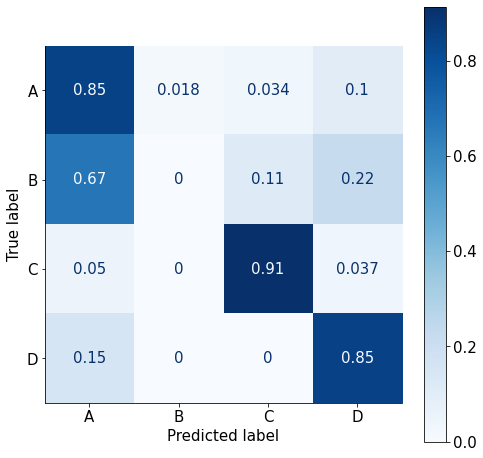

In [173]:
fig, ax = plt.subplots(figsize=(8,8))
cm = confusion_matrix(results['y_true'], results['thresholded_preds_2'], labels= ['A','B','C','D'], normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels= ['A','B','C','D'])
disp.plot(cmap=plt.cm.Blues, ax=ax)

In [159]:
print('F1 micro score: {:.3f}'.format(f1_score(results['y_true'], results['thresholded_preds_2'], average='micro')))
print('F1 macro score: {:.3f}'.format(f1_score(results['y_true'], results['thresholded_preds_2'], average='macro')))
print('F1 weighted score: {:.3f}'.format(f1_score(results['y_true'], results['thresholded_preds_2'], average='weighted')))

F1 micro score: 0.862
F1 macro score: 0.577
F1 weighted score: 0.876


If we consider class B not important at all, we end up with better results for class A especially. This tells us that the discriminability between class A and B was the weakest.

## Conclusion

Let's compare the performances of the MLSTCM-FCN against the LGBM.

<img src="./images/lgbm_roc_curves.png" style="width: 700px;"/>
<img src="./images/mlstm_roc_curves.png" style="width: 700px;"/>

And the AUC scores:

| Model     | A vs rest | B vs rest  | C vs rest | D vs rest | Macro AUROC |
|-----------|-----------|------------|-----------|-----------|-------------|
| LGBM      | 0.961     | 0.812      | 0.98      | 0.942     | 0.924       |
| MLSTM-FCN | 0.963     | 0.871      | 0.985     | 0.964     | 0.946       |

The MLSTM-FCN proves to be better than the LGBM. For both models, class B is the hardest class to classify. This could be due to the small number of valid observations to train on; in our full dataset, after dropping the non-representative chunks, we were left with only 34 observations for class B. Nonetheless, even with this small amount of data, our MLSTM-FCN was able to achieve an AUROC of 0.86. If we had more valid observations, our model would undoubtedly do even better.

We must remember however, that these 2 models were trained on different types of data. The LGBM was trained on features extracted from signals, while the MLSTM-FCN was trained directly on the raw signals plus the cD3 reconstructed signals. Therefore there isn't a straightforward 1-to-1 comparison of these models. What we have learnt is that it is in fact possible to work with signal/time series data in 2 ways. One is to use extracted scalar features with traditional classifiers, which is less data-intensive for the model. However, this requires domain knowledge about what kinds of extracted features make sense to use, and also how to then extract these features. In our case, we applied Discrete Waveform Transformation to extract specific coefficients from our EEG data to engineer the total energy in each frequency band, and used these as features. The other way is to use the raw signals as vector inputs to a CNN. In our case, we took this a step further, and applied the findings from our LGBM analysis to also engineer a reconstructed signal from only the frequency band corresponding to the cD3 coefficients, 32-64 Hz.

Given that the MLSTM-FCN performed the best, is reasonably lightweight, and requires less preprocessing as compared to the LGBM, we recommend the use of the MLSTM-FCN model for operational use.

## Recommendations

In the context of building a classifier to help pilots, these are some of our recommendations for taking this project further.

1. Get measurements under more realistic flight conditions
    - there is a genuine concern that the results of this project cannot be generalized to actual attentional state monitoring during flight because none of the experiments approximate events that occur during real flying.
    
    
2. Choose more relevant attentional states to learn
    - Like discussed elsewhere in the project, the attentional state of Startled/Surprised is not a very useful state to predict. This state is already very visceral by nature, and it is almost impossible that pilots will be unaware of being startled. 
    - In contrast, it may be more beneficial to measure a state like drowsiness or daydreaming, whereby a pilot slips into a disengaged state unintentionally. Such states regularly occur in drivers engaged in long-distance trips, like with truckers for example, and a state like this is significantly more detrimental to operational safety.
    
    
3. Create a classifier for each individual pilot
    - biomedical signals are highly variable from individual to individual. Training on one pilot's readings in order to build a classifier to classify attentional states in other pilots is akin to building a housing price prediction model by training on Singapore housing data and using it to predict New York house prices.

## Further discussion
I'd like to highlight a few issues faced over the course of this project, and draw lessons from them.

1. Imbalanced dataset
     
     From the start we were challenged by the fact that the negative attentional states we were interested in formed a small minority of all the observations we had. Distracted Attentional states made up roughly 4.5% of the dataset, while Startled/Surprised attentional states made up roughly 2.5%. This made it challenging for our LGBM classifier initially. We tried out resampling techniques, and found out that sometimes its not the best idea to fully balance all our classes. Rather, it might be better to accept some degree of imbalance, and only partially resample our minority classes to acquire more training data points while avoiding overly distorting the true distribution of our minority classes. In our case, we specified the amount of resampling to be done for classes B and D so that some of the imbalance was alleviated, but not all.
     
     
2. Imprecise class labelling
    
    One observation we made regarding our class B, the Startled/Surprised class, is that the event wasn't very well defined. The data description said that this event was defined as showing pilots a jumpscare in a movie clip. A jumpscare is an instantaneous event in a movie that elicits a strong, immediate, and *visceral* response. The event however, as labelled in the experiments, lasts for up to 15 seconds. Anyone who has watched horror movies will know that jumpscares elicit the strongest response at the onset of the event, and that the feeling evoked does not persist at the same intensity following the event. Rather, people would slowly come down from that state of startledness. This means that it is imprecise for the class B label to represent the actual attentional state of the pilot for the full 15 second duration of the supposed event during the experiment. Imprecise class labelling can actually make our classification task even harder by masking the true patterns within the observations that truly represent the class by mixing in non-representative samples in that class. This leads me to the next issue.
    

3. Not all data is good data

    In cases where one has good reason to believe that the data they have on hand is of detrimental quality, it is better to get rid of that data, even if it means losing a significant number of observations you have for your already small minority class. In our case, we chose to discard more than half of the samples that represented class B, because we felt that they were not representative of the class. In doing so, our dataset was only left with 1% of the observations being from class B. However, by making this move, we actually *improved* the performance of our classifier, and we were able to bring up the AUROC for class B vs the rest to above 0.8. 
    
    
4. Take lead from people smarter than you
    
    In figuring out how I could use raw signal inputs to train a classifier, I was lost at first. I knew I needed some kind of neural network, but I didn't know what exactly. Instead of blindly trying to build something arbitrary, it is much more fruitful to sit down, do some research, and see what people smarter than you have tried before. Because of this, I was able to implement 3 different kinds of CNN architectures that were already well-researched. This cut down the amount of time needed to build models, and instead I could spend my time tuning hyperparameters and quickly making a decision about the feasibility of the model.
    

5. Roadblocks and the value of failing fast

    When I was building the XCM, I wasn't confident that I had interpreted the architecture correctly. I was concerned in particular about the dimensions of the inputs demanded by each layer. In trying to implement and tune this model, I was consistently unable to beat the LGBM model's performance, and furthermore, I was unable to get the model to converge stably. I had already spent 3 days trying to work this model, and I could easily have chosen to spend another week trying to fix it. Instead, I went back to the paper I got the XCM from, looked at other models tested out by the authors, and moved on to trying another one of them, the MLSTM-FCN. This model turned out to be easier to implement, faster to train, and in the end it produced better results than the XCM and the LGBM even. Fail fast, seek out the next course of action, and you could make progress way faster than if you had stuck to one thing only.